In [1]:
from prototype04_cbcsnrs import CBCSNRsBase, compute_bilby_snr
import numpy as np
import pylab as plt
import bilby
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from pycbc.detector import Detector
from datetime import datetime

# modified Findchirp method, or Half Scaling method. 
* SNR : $$ \rho= \left( \frac{1 Mpc}{D_{eff}} \right)\mathcal{A}_{1Mpc} \sqrt{ 4\int_0^\infty \frac{f^{-7/3}}{S_n(f)}df } $$

* Half scaled SNR : $$ \rho_{1/2} = \left( \frac{D_{eff}}{1 Mpc} \right)\mathcal{A}_{1Mpc}^{-1} \times \rho $$
                    $$ \rho_{1/2} = \sqrt{ 4\int_0^\infty \frac{f^{-7/3}}{S_n(f)}df } $$
                    
* It shouldn't depend on the GW parameters
* It depends on the noise curve of the detector : $S_n(f)$

# taking care of units
* $\mathcal{M}$ : chirp mass in $M_{\odot}$, $\mathcal{D}$: luminosity distance in Mpc. 
* $F_+,F_{\times}$: Antenna pattern, $\iota$: inclination angle
$$\mathcal{A}_{1Mpc}=\left(\frac{5}{24\pi}\right)^{1/2}\left(\frac{GM_{\odot}/c^2}{1Mpc}\right)\left(\frac{\pi GM_{\odot}}{c^3}\right)^{-1/6}\left(\frac{\mathcal{M}}{M_{\odot}}\right)^{5/6} $$
$$ \mathcal{D}_{eff} = \mathcal{D}\left[ F_+^2\left(\frac{1+cos^2\iota}{2}\right) + F_{\times}^2 cos^2\iota \right]^{-1/2} $$ 

* Half scaled SNR : 
$$ \rho_{1/2} = \left( \frac{D_{eff}}{1 Mpc} \right) \mathcal{M}^{-5/6} \times \rho $$
$$ \rho_{1/2} = \left(\frac{5}{24\pi}\right)^{1/2}\left(\frac{GM_{\odot}/c^2}{1Mpc}\right)\left(\frac{\pi GM_{\odot}}{c^3}\right)^{-1/6}\left(\frac{1}{M_{\odot}}\right)^{5/6} \sqrt{ 4\int_0^\infty \frac{f^{-7/3}}{S_n(f)}df } $$

In [2]:
# Hemanta's code
# for an array of each parameter
# only for freqency domain waveform
# 3 detector case
# zero spin
# let geocent time be fixed (according to a selected observing run)
def compute_bilby_snr_(mass_1, mass_2, luminosity_distance, theta_jn, \
                      psi, phase, geocent_time, ra, dec, duration=16.0, sampling_frequency=4096, \
                      waveform_arguments=  dict(waveform_approximant = "TaylorF2", reference_frequency = 30., \
                                                minimum_frequency = 20) ):
    
    mass_1_, mass_2_, luminosity_distance_, \
    theta_jn_, psi_, phase_, ra_, dec_ = np.array([mass_1]).reshape(-1), np.array([mass_2]).reshape(-1), \
                                        np.array([luminosity_distance]).reshape(-1), np.array([theta_jn]).reshape(-1), \
                                        np.array([psi]).reshape(-1), np.array([phase]).reshape(-1), \
                                        np.array([ra]).reshape(-1), np.array([dec]).reshape(-1)
    
    bilby.core.utils.logger.disabled = True
    np.random.seed(88170235)
    nsamples = np.size(mass_1_)
    
    # initialize interferometer object
    # it is ideal to initialized it outside the for loop
    waveform_generator = bilby.gw.WaveformGenerator(
            duration=duration,
            sampling_frequency=sampling_frequency,
            frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
            parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
            waveform_arguments=waveform_arguments,)
    
    ifos_ = bilby.gw.detector.InterferometerList(["L1", "H1", "V1"])
    ifos_.set_strain_data_from_power_spectral_densities(
        sampling_frequency=sampling_frequency,
        duration=duration,
        start_time=geocent_time - 16,
    )
    
    opt_snr0 = []
    opt_snr1 = []
    opt_snr2 = []
    # f_max=4096/2  
    for i in range(nsamples):
        ifos = ifos_
        injection_parameters = dict(mass_1=mass_1_[i],mass_2=mass_2_[i],a_1=0.,a_2=0.,tilt_1=0.,tilt_2=0.,phi_12=0.,\
                                    phi_jl=0.,luminosity_distance=luminosity_distance_[i],theta_jn=theta_jn_[i],psi=psi_[i], \
                                    phase=phase_[i],geocent_time=geocent_time,ra=ra_[i],dec=dec_[i])
        ifos.inject_signal(
            waveform_generator=waveform_generator, parameters=injection_parameters, raise_error=False
        );
        
        opt_snr0.append(ifos[0].meta_data['optimal_SNR'])
        opt_snr1.append(ifos[1].meta_data['optimal_SNR'])
        opt_snr2.append(ifos[2].meta_data['optimal_SNR'])
        
    opt_snr0,opt_snr1,opt_snr2 = np.array(opt_snr0),np.array(opt_snr1),np.array(opt_snr2)
    opt_snr_net = np.sqrt(opt_snr0**2 + opt_snr1**2 + opt_snr2**2)

    return(np.array([opt_snr0, opt_snr1, opt_snr2, opt_snr_net]))

In [3]:
# Otto's code
# Function for computing bilby SNRs
def compute_bilby_snr(mass_1, mass_2, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, luminosity_distance, theta_jn, psi, phase, geocent_time, ra, dec, duration=4.0, sampling_frequency=4096, waveform_arguments=  dict(waveform_approximant = "IMRPhenomXPHM", reference_frequency = 30., minimum_frequency = 20), list_of_detectors=["L1", "H1", "V1"]):
    # Set the duration and sampling frequency of the data segment that we're
    # going to inject the signal into
    # Specify the output directory and the name of the simulation.
    bilby.core.utils.logger.disabled = True
    # Set up a random seed for result reproducibility. 
    np.random.seed(88170235)
    # We are going to inject a binary black hole waveform.  We first establish a
    # dictionary of parameters that includes all of the different waveform
    # parameters, including masses of the two black holes (mass_1, mass_2),
    # spins of both black holes (a, tilt, phi), etc.
    injection_parameters = dict(
        mass_1=mass_1,
        mass_2=mass_2,
        a_1=a_1,
        a_2=a_2,
        tilt_1=tilt_1,
        tilt_2=tilt_2,
        phi_12=phi_12,
        phi_jl=phi_jl,
        luminosity_distance=luminosity_distance,
        theta_jn=theta_jn,
        psi=psi,
        phase=phase,
        geocent_time=geocent_time,
        ra=ra,
        dec=dec
    )
    # Create the waveform_generator using a LAL BinaryBlackHole source function
    # the generator will convert all the parameters
    waveform_generator = bilby.gw.WaveformGenerator(
        duration=duration,
        sampling_frequency=sampling_frequency,
        frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
        parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
        waveform_arguments=waveform_arguments,
    )
    # Set up interferometers.  In this case we'll use two interferometers
    # (LIGO-Hanford (H1), LIGO-Livingston (L1). These default to their design
    # sensitivity
    ifos = bilby.gw.detector.InterferometerList(list_of_detectors)
    ifos.set_strain_data_from_power_spectral_densities(
        sampling_frequency=sampling_frequency,
        duration=duration,
        start_time=injection_parameters["geocent_time"] - 2,
    )
    ifos.inject_signal(
        waveform_generator=waveform_generator, parameters=injection_parameters, raise_error=False
    );
    network_optimal_snr_squared = 0
    for i in range(len(ifos)):
        single_detector_optimal_snr = ifos[i].meta_data['optimal_SNR']
        # Sum in quadrature
        network_optimal_snr_squared = network_optimal_snr_squared + single_detector_optimal_snr**2
    network_optimal_snr = np.sqrt(network_optimal_snr_squared)
    return network_optimal_snr

In [362]:
# putting constraint on mass_2, so mass_2 can be <1.0solar_mass; which is the neutron star min mass limit
def interpolation_table(q,iota,mchirp_min, mchirp_max, nsamples, psi=0., phase=0., ra=0., dec=0., geocent_time=1246527184.169434, \
                        waveform_arguments= dict(waveform_approximant = "TaylorF2", \
                                               reference_frequency = 30., minimum_frequency = 20)):
    # preferably: nsamples = 200
    mchirp = np.linspace(mchirp_min, mchirp_max, nsamples)
    mass_1 = (mchirp*(1+q)**(1/5))/q**(3/5)
    mass_2 = mchirp*q**(2/5)*(1+q)**(1/5)
    
    idx = mass_2>=1. # on the condition that neutron stars cannot be smaller than 1 solar_mass
    mass_1 = mass_1[idx]
    mass_2 = mass_2[idx]
    mtot = mass_1+mass_2
    geocent_time = geocent_time
    luminosity_distance =100.*np.ones(nsamples)
    # geocent_time cannot be array here
    theta_jn, psi, phase, ra, dec = iota*np.ones(nsamples), psi*np.ones(nsamples), \
                                        phase*np.ones(nsamples), ra*np.ones(nsamples), dec*np.ones(nsamples)
    
    opt_snr_unscaled = compute_bilby_snr_(mass_1, mass_2, luminosity_distance, theta_jn, psi, \
                                          phase, geocent_time, ra, dec, duration=16., sampling_frequency=4096, \
                                          waveform_arguments= waveform_arguments)  
    
    A2 = mchirp**(5./6.)
    ##############################
    Fp, Fc = Detector('L1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff2 = luminosity_distance/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    L1snr_ = (Deff2/A2)*opt_snr_unscaled[0]
    ##############################
    Fp, Fc = Detector('H1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff2 = luminosity_distance/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    H1snr_ =  (Deff2/A2)*opt_snr_unscaled[1]
    ##############################
    Fp, Fc = Detector('V1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff2 = luminosity_distance/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    V1snr_ =  (Deff2/A2)*opt_snr_unscaled[2]
    
    net_snr = np.sqrt(L1snr_**2 + H1snr_**2 + V1snr_**2)
    
    return(np.array( [mtot,mchirp,L1snr_,H1snr_,V1snr_,net_snr] ))

In [6]:
# To find half-scaled snr
# without putting constraint on mass_2, so mass_2 can be <1.0solar_mass; which is the neutron star min mass limit
def interpolation_table(q,iota,mchirp_min, mchirp_max, nsamples, psi=0., phase=0., ra=0., dec=0., geocent_time=1246527184.169434, \
                        waveform_arguments= dict(waveform_approximant = "TaylorF2", \
                                               reference_frequency = 30., minimum_frequency = 20)):
    # preferably: nsamples = 200
    mchirp = np.geomspace(mchirp_min, mchirp_max, nsamples)
    mass_1 = (mchirp*(1+q)**(1/5))/q**(3/5)
    mass_2 = mchirp*q**(2/5)*(1+q)**(1/5)
    mtot = mass_1+mass_2
    geocent_time = geocent_time
    luminosity_distance =100.*np.ones(nsamples)
    # geocent_time cannot be array here
    theta_jn, psi, phase, ra, dec = iota*np.ones(nsamples), psi*np.ones(nsamples), \
                                        phase*np.ones(nsamples), ra*np.ones(nsamples), dec*np.ones(nsamples)
    
    opt_snr_unscaled = compute_bilby_snr_(mass_1, mass_2, luminosity_distance, theta_jn, psi, \
                                          phase, geocent_time, ra, dec, duration=16., sampling_frequency=4096, \
                                          waveform_arguments= waveform_arguments)  
    
    A2 = mchirp**(5./6.)
    ##############################
    Fp, Fc = Detector('L1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff2 = luminosity_distance/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    L1snr_ = (Deff2/A2)*opt_snr_unscaled[0]
    ##############################
    Fp, Fc = Detector('H1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff2 = luminosity_distance/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    H1snr_ =  (Deff2/A2)*opt_snr_unscaled[1]
    ##############################
    Fp, Fc = Detector('V1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff2 = luminosity_distance/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    V1snr_ =  (Deff2/A2)*opt_snr_unscaled[2]
    
    net_snr = np.sqrt(L1snr_**2 + H1snr_**2 + V1snr_**2)
    
    return(np.array( [mtot,mchirp,L1snr_,H1snr_,V1snr_,net_snr] ))

# To test $\rho_{1/2}$ variation with mass ratio
* Below, mchirp_min is chosen so that mass_2>1solar_mass at q=0.4
* i avoid high mass as the curve become more difficult to fit

In [20]:
# interpolation_table(q,iota,mchirp_min, mchirp_max, nsamples)
table1p0 = interpolation_table(1.,0., 10, 60, 30) #q=1.0
table0p8 = interpolation_table(0.8,0., 10, 60, 30) #q=0.8
table0p6 = interpolation_table(0.6,0., 10, 60, 30) #q=0.6
table0p4 = interpolation_table(0.4,0., 10, 60, 30) #q=0.4

# halfed scaled SNR variation with $M_{tot}$, $\mathcal{M}$ and $m_1$ at three different $q$ (0.1,0.7,0.4)
* halfed scaled SNR = (Deff2/A2)*opt_snr_unscaled

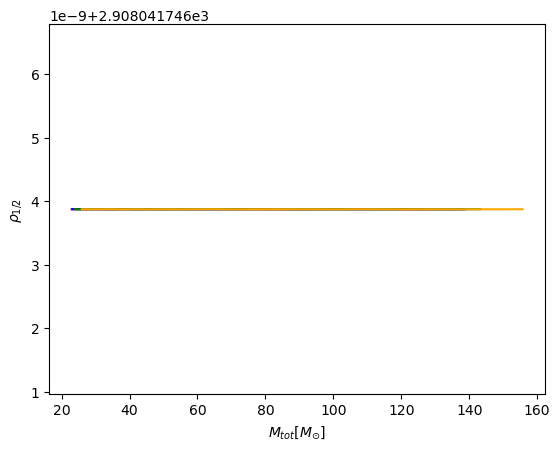

In [23]:
# halfed scaled SNR vs mtot
plt.plot(table1p0[0],table1p0[3], color='red' )
plt.plot(table0p8[0],table0p8[3], color='blue' )
plt.plot(table0p6[0],table0p6[3], color='green' )
plt.plot(table0p4[0],table0p4[3], color='orange' )
plt.xlabel(r"$M_{tot} [M_{\odot}]$")
plt.ylabel(r"$\rho_{1/2}$")
plt.show()

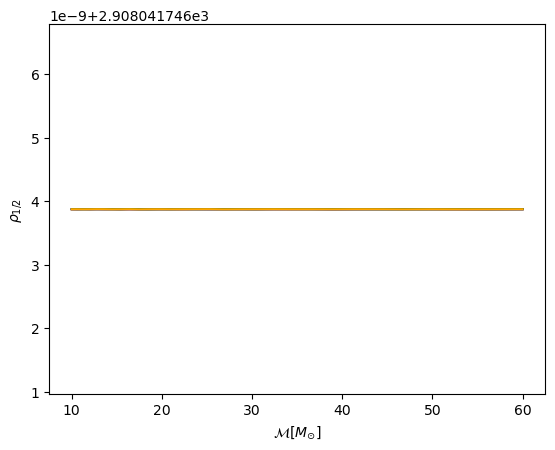

In [24]:
# halfed scaled SNR vs mchirp
plt.plot(table1p0[1],table1p0[3], color='red' )
plt.plot(table0p8[1],table0p8[3], color='blue' )
plt.plot(table0p6[1],table0p6[3], color='green' )
plt.plot(table0p4[1],table0p4[3], color='orange' )
plt.xlabel(r"$\mathcal{M} [M_{\odot}]$")
plt.ylabel(r"$\rho_{1/2}$")
plt.show()

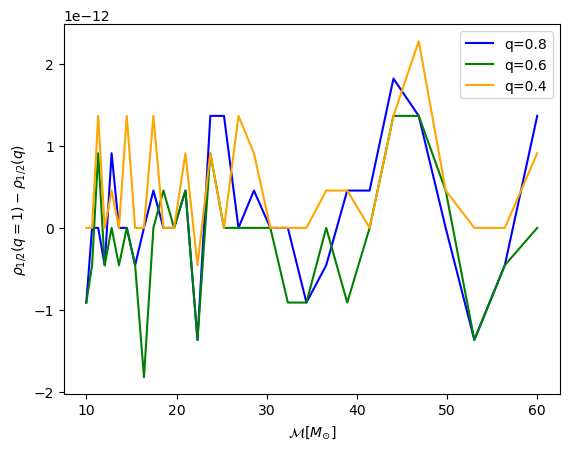

In [31]:
# halfed scaled SNR-difference vs mchirp
plt.plot(table0p8[1],table1p0[3]-table0p8[3], color='blue' )
plt.plot(table0p6[1],table1p0[3]-table0p6[3], color='green' )
plt.plot(table0p4[1],table1p0[3]-table0p4[3], color='orange' )
plt.gca().legend(('q=0.8','q=0.6','q=0.4'))
plt.xlabel(r"$\mathcal{M} [M_{\odot}]$")
plt.ylabel(r"$\rho_{1/2}(q=1)-\rho_{1/2}(q)$")
plt.show()

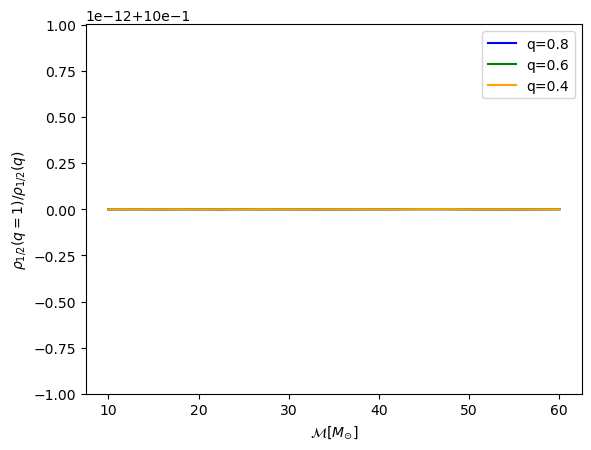

In [32]:
# halfed scaled SNR-ratio vs mchirp
plt.plot(table0p8[1],table1p0[3]/table0p8[3], color='blue' )
plt.plot(table0p6[1],table1p0[3]/table0p6[3], color='green' )
plt.plot(table0p4[1],table1p0[3]/table0p4[3], color='orange' )
plt.gca().legend(('q=0.8','q=0.6','q=0.4'))
plt.xlabel(r"$\mathcal{M} [M_{\odot}]$")
plt.ylabel(r"$\rho_{1/2}(q=1)/\rho_{1/2}(q)$")
plt.show()

* half scaled snr variation in TaylorF2 is negligible with mass ratio
* $\rho_{1/2}(\mathcal{M},q)=$ Constant
* this is not the case for XPHM model

# half scaled SNR variation with $\mathcal{M}$ at three different detectors

In [63]:
# return values [mtot,mchirp,L1snr_,H1snr_,V1snr_,net_snr]
table1p0 = interpolation_table(1.,0., 1, 60, 30)

* $\rho_{1/2}(\text{L1})=$ table1p0[2]
* $\rho_{1/2}(\text{H1})=$ table1p0[3]
* $\rho_{1/2}(\text{V1})=$ table1p0[4]

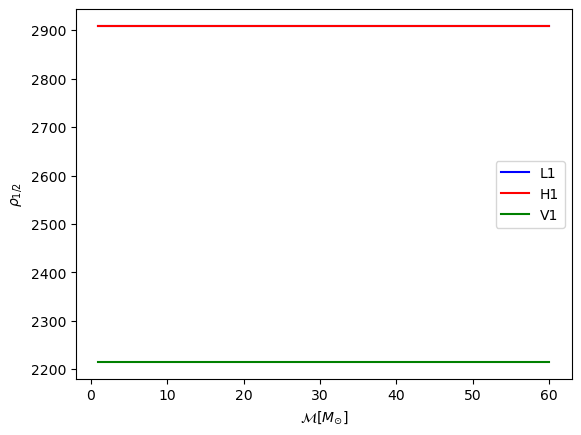

In [64]:
# L1 Vs H1 Vs V1
plt.plot(table1p0[1],table1p0[2], color='blue' )
plt.plot(table1p0[1],table1p0[3], color='red' )
plt.plot(table1p0[1],table1p0[4], color='green')
plt.gca().legend(('L1','H1','V1'))
plt.xlabel(r"$\mathcal{M} [M_{\odot}]$")
plt.ylabel(r"$\rho_{1/2}$")
plt.show()

* To find the constant in, $\rho_{1/2}(\mathcal{M},q)=$ Constant

In [65]:
param = [np.average(table1p0[2]),np.average(table1p0[3]),np.average(table1p0[4])]
print(param)

[2908.2661468129972, 2908.0417461038714, 2214.693865936319]


In [66]:
half_snr_L1

array([2908.26614681, 2908.26615867, 2908.26632043, 2908.26702855,
       2908.26902861, 2908.27349964, 2908.28194782, 2908.29537868,
       2908.31196881, 2908.32445408, 2908.32400147, 2908.31097912,
       2908.29443183, 2908.28129605, 2908.27313061, 2908.26885092,
       2908.26695829, 2908.26630055, 2908.26615617, 2908.26614681])

* for TaylorF2, half scaled snr can be simplified with a single constant line (for iota=0.)
* it doesn't depend on q
* it can be affected by choice of psd

# half scaled SNR variation with chirp mass ($\mathcal{M}$) at varying inclination angle ($\iota$)

* first check with bilby snr without half scaling

In [92]:
# return(np.array([opt_snr_net, opt_snr0, opt_snr1, opt_snr2]))
nn = 20
ii = np.linspace(0.01,np.pi,nn)
mm = 50*np.ones(nn)
waveform_arguments= dict(waveform_approximant = "TaylorF2", reference_frequency = 50., minimum_frequency = 20)
opt_snr_unscaled1p0 = compute_bilby_snr_(mm,mm*0.7,100*np.ones(nn), ii, np.zeros(nn), \
                                          np.zeros(nn), 1246527184.169434, np.zeros(nn), np.zeros(nn), duration=16., sampling_frequency=4096, \
                                          waveform_arguments= waveform_arguments)

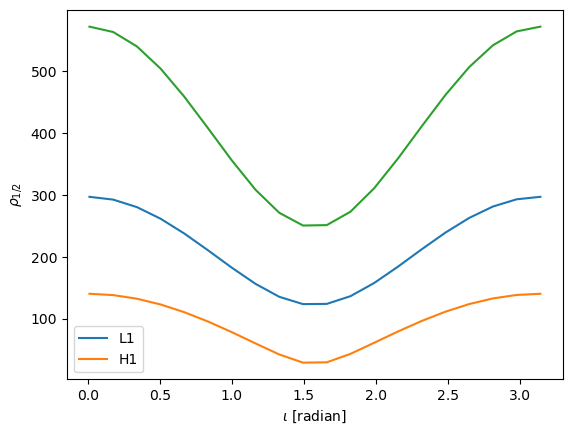

In [95]:
plt.plot(ii,opt_snr_unscaled1p0[1]) #L1
plt.plot(ii,opt_snr_unscaled1p0[2]) #H1
plt.plot(ii,opt_snr_unscaled1p0[3]) #V1
plt.gca().legend(('L1','H1'))
plt.xlabel(r"$\iota$ [radian]")
plt.ylabel(r"$\rho_{1/2}$")
plt.show()

* $\rho_{1/2}$ variation with $\iota$
* find a analytic form to find the curve

In [129]:
nn = 100
ii = np.linspace(0.01,np.pi,nn)
mass_ratio_ = 1.
half_snr_L1 = []
half_snr_H1 = []
half_snr_V1 = []

for j in range(nn):
    buffer = interpolation_table(mass_ratio_,ii[j],1, 100, 5)
    half_snr_ = np.average(buffer[2]) # for L1 only
    half_snr_L1.append(half_snr_) 
    half_snr_ = np.average(buffer[3]) # for H1 only
    half_snr_H1.append(half_snr_)
    half_snr_ = np.average(buffer[4]) # for V1 only
    half_snr_V1.append(half_snr_)
    
half_snr_L1 = np.array(half_snr_L1)
half_snr_H1 = np.array(half_snr_H1)
half_snr_V1 = np.array(half_snr_V1)

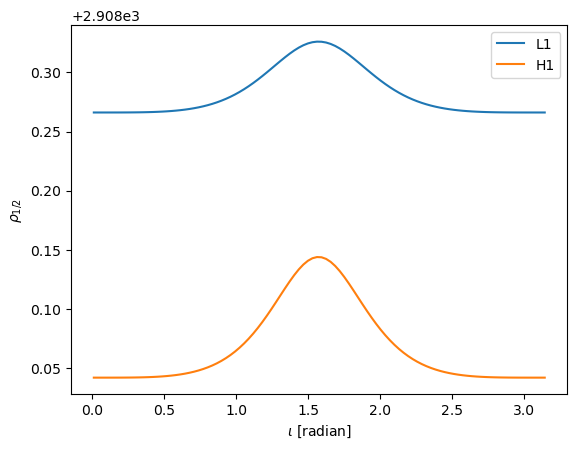

In [130]:
plt.plot(ii,half_snr_L1) #L1
plt.plot(ii,half_snr_H1) #H1
#plt.plot(ii,half_snr_V1) #V1
plt.gca().legend(('L1','H1'))
plt.xlabel(r"$\iota$ [radian]")
plt.ylabel(r"$\rho_{1/2}$")
plt.show()

In [131]:
# how much is the variation in percentage
(np.max(half_snr_L1)-np.min(half_snr_L1))/np.average(half_snr_L1)*100

0.0020616474243377687

* the variation is very small, and can be as well assumed as const line
* But if want to take care of it, we need a analytic formula that fits the distribution
* scipy.optimize.curve_fit will be use to find the parameter of this formula (gaussian)

In [137]:
# min values of the gaussians
print(ii[np.argmax(half_snr_L1)],ii[np.argmax(half_snr_H1)],ii[np.argmax(half_snr_V1)])

1.5599802022818168 1.5599802022818168 1.5599802022818168


In [ ]:
# mean of the gaussian 
print(np.(half_snr_L1),np.min(half_snr_H1),np.min(half_snr_V1))

In [149]:
# D constant is the min of half_snr
def Gauss_L1(x, A, B):
    y = A*np.exp(-B*(x-1.55998)**2)+2908.2661468129972
    return y

def Gauss_H1(x, A, B):
    y = A*np.exp(-B*(x-1.55998)**2)+2908.0417461038705
    return y

def Gauss_V1(x, A, B):
    y = A*np.exp(-B*(x-1.55998)**2)+2214.6938659363186
    return y

In [150]:
param_L1 = curve_fit(Gauss_L1, ii, half_snr_L1)[0]
param_H1 = curve_fit(Gauss_H1, ii, half_snr_H1)[0]
param_V1 = curve_fit(Gauss_V1, ii, half_snr_V1)[0]

In [151]:
print(param_L1)
print(param_H1)
print(param_V1)

[0.05891279 4.06005758]
[0.09930141 4.61914722]
[ 1.07749972 13.87164264]


* ioto effect has to be cancelled out after bilby SNR is multiplied by $D_{eff}$ , but not quite
* so now, 
* $\rho_{1/2}(\text{L1})=0.05891279 e^{(-4.06005758(x-1.55998)^2)}+2908.2661468129972$
* $\rho_{1/2}(\text{H1})=0.09930141 e^{(-4.61914722(x-1.55998)^2)}+2908.0417461038705$
* $\rho_{1/2}(\text{V1})=1.07749972 e^{(-13.87164264(x-1.55998)^2)}+2214.6938659363186$

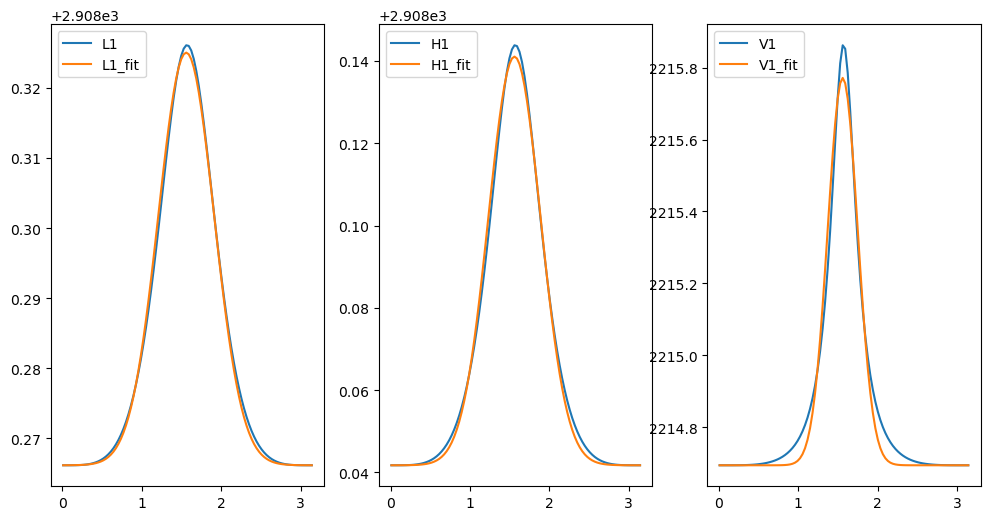

In [156]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,
                                    figsize=(12, 6))

ax0.plot(ii,half_snr_L1, label='L1') #L1
ax0.plot(ii,0.05891279*np.exp(-4.06005758*(ii-1.55998)**2)+2908.2661468129972,label='L1_fit')
ax0.legend(loc="upper left")

ax1.plot(ii,half_snr_H1, label='H1') #L1
ax1.plot(ii,0.09930141*np.exp(-4.61914722*(ii-1.55998)**2)+2908.0417461038705,label='H1_fit')
ax1.legend(loc="upper left")

ax2.plot(ii,half_snr_V1, label='V1') #L1
ax2.plot(ii,1.07749972*np.exp(-13.87164264*(ii-1.55998)**2)+2214.6938659363186,label='V1_fit')
ax2.legend(loc="upper left")


plt.show()

# scaling_snr Vs bilby_snr with $\iota$ variation

In [353]:
# generate half scaled snrs table, if iota variation is not taken into account
# interpolation_table(q,iota,mchirp_min, mchirp_max, nsamples)
table1p0 = interpolation_table(1.,1.6, 1, 100, 100)
param = [np.average(table1p0[2]),np.average(table1p0[3]),np.average(table1p0[4])]
print(param)

[2908.3258952308797, 2908.1433595412736, 2215.839700516268]


In [354]:
# simplified scaled_snr
# without iota scaling
# without any interpolation table
# considering, half scaled snr is just a const line, not affected by chirp_mass and mass_ratio (for TaylorF2) 
def scaled_snr_(mass_1, mass_2, iota, Dl, psi, geocent_time, ra, dec):
    
    chirp_mass = ( (mass_1*mass_2)**(3/5) )/( (mass_1+mass_2)**(1/5) )
    mtot = mass_2+mass_1
    A1 = chirp_mass**(5./6.)
    geocent_time = geocent_time
    # snr_HalfScaled = [2908.2661468129972, 2908.0417461038714, 2214.693865936319]
    # for L1,H1,V1 respectively
    ##############################
    Fp, Fc = Detector('L1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    L1snr_ = (A1/Deff1)*2908.3258952308797
    ##############################
    Fp, Fc = Detector('H1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    H1snr_ =  (A1/Deff1)*2908.1433595412736
    ##############################
    Fp, Fc = Detector('V1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    V1snr_ =  (A1/Deff1)*2215.839700516268
    
    net_snr = np.sqrt(L1snr_**2 + H1snr_**2 + V1snr_**2)
    
    return(np.array( [mtot,chirp_mass,L1snr_,H1snr_,V1snr_,net_snr] ))

In [283]:
# taking care of iota variation, at half_snr level
# without any interpolation table
# considering, half scaled snr is just a const line, not affected by chirp_mass and mass_ratio (for TaylorF2) 
def scaled_snr_(mass_1, mass_2, iota, Dl, psi, geocent_time, ra, dec):
    
    chirp_mass = ( (mass_1*mass_2)**(3/5) )/( (mass_1+mass_2)**(1/5) )
    mtot = mass_2+mass_1
    A1 = chirp_mass**(5./6.)
    geocent_time = geocent_time
    # snr_HalfScaled = [2908.2661468129972, 2908.0417461038714, 2214.693865936319]
    # for L1,H1,V1 respectively
    ##############################
    Fp, Fc = Detector('L1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    L1snr_ = (A1/Deff1)*(0.05891279*np.exp(-4.06005758*(iota-1.55998)**2)+2908.2661468129972)
    ##############################
    Fp, Fc = Detector('H1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    H1snr_ =  (A1/Deff1)*(0.09930141*np.exp(-4.61914722*(iota-1.55998)**2)+2908.0417461038705)
    ##############################
    Fp, Fc = Detector('V1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    V1snr_ =  (A1/Deff1)*(1.07749972*np.exp(-13.87164264*(iota-1.55998)**2)+2214.6938659363186)
    
    net_snr = np.sqrt(L1snr_**2 + H1snr_**2 + V1snr_**2)
    
    return(np.array( [mtot,chirp_mass,L1snr_,H1snr_,V1snr_,net_snr] ))

* Test: Half_SNR method Vs Bilby_SNR calculation

In [165]:
# Half_SNR method
snr_=scaled_snr_(mm1, mm2, 0., 80., 0., 1246527184.169434, 0., 0.)
print('SNRs: L1={}, H1={}, V1={}'.format(snr_[2], snr_[3], snr_[4]))

SNRs: L1=1007.2635422922259, H1=639.0422596853837, V1=302.0605343721839


In [166]:
# bilby_snr method
snr_ = compute_bilby_snr_(mm1, mm2, 80., 0., 0., 0., 1246527184.169434, 0., 0., duration=16., sampling_frequency=4096, \
                                          waveform_arguments= dict(waveform_approximant = "TaylorF2", \
                                                                                       reference_frequency = 30., \
                                                                                       minimum_frequency = 20))
print('SNRs: L1={}, H1={}, V1={}'.format(snr_[0,0], snr_[1,0], snr_[2,0]))

SNRs: L1=1007.2635412480887, H1=639.0422593989413, V1=302.06053437218384


* almost identical for $\iota=0.0$ case.
* now vary inclination angle.

In [256]:
# only L1
# fixed parameters: ra,dec
# vary all other parameter fixed
# scaled_snr_(mass_1, mass_2, iota, Dl, psi, geocent_time, ra, dec)
nn = 50
ii = np.linspace(0.01,np.pi,nn)
chirp_mass_ = np.linspace(10,100,nn)
mass_ratio_ = np.random.uniform(0.2,1,size=nn)
mass_1_ = (chirp_mass_*(1+mass_ratio_)**(1/5))/mass_ratio_**(3/5)
mass_2_ = chirp_mass_*mass_ratio_**(2/5)*(1+mass_ratio_)**(1/5)
my_snr_ = []
bilby_snr_ = []

for j in range(nn):
    snr_ = scaled_snr_(mm1, mm2, ii[j], 100., 0., 1246527184.169434, 0., 0.)
    my_snr_.append(snr_[2]) # L1 only
    snr_ = compute_bilby_snr_(mm1, mm2, 100., ii[j], 0., 0., 1246527184.169434, 0., 0., duration=16., sampling_frequency=4096, \
                                          waveform_arguments= dict(waveform_approximant = "TaylorF2", \
                                                                                       reference_frequency = 50., \
                                                                                       minimum_frequency = 20))
    bilby_snr_.append(snr_[0,0])
    
my_snr_ = np.array(my_snr_)
bilby_snr_ = np.array(bilby_snr_)

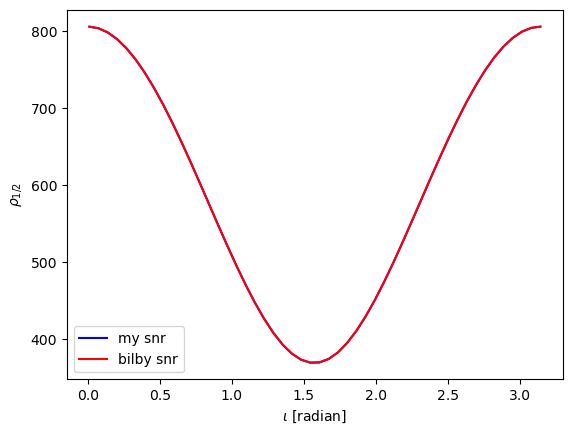

In [228]:
plt.plot(ii,my_snr_, color='blue')  
plt.plot(ii,bilby_snr_, color='red')  
plt.gca().legend(('my snr','bilby snr'))
plt.xlabel(r"$\iota$ [radian]")
plt.ylabel(r"$\rho_{1/2}$")
plt.show()

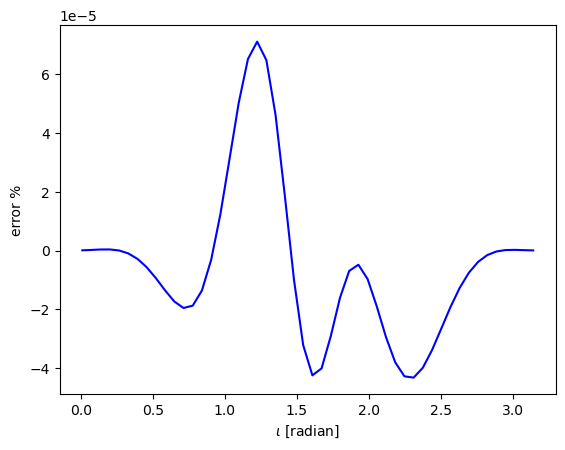

In [230]:
plt.plot(ii,(my_snr_-bilby_snr_)/bilby_snr_*100, color='blue')  
plt.xlabel(r"$\iota$ [radian]")
plt.ylabel(r"error %")
plt.show()

* the errors are very small, so I will ignored it
* now, include psi and phase
* atleast it shoould not depend on phase

* if iota is not taken care of at the half-scaled lavel
* use the other scaled_snr_ function with $\rho_{1/2}=const$ 

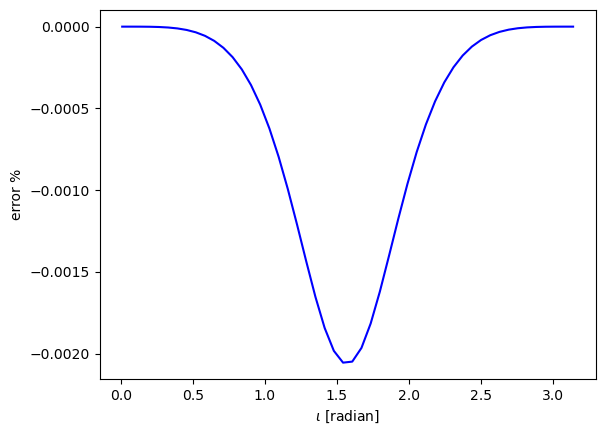

In [257]:
plt.plot(ii,(my_snr_-bilby_snr_)/bilby_snr_*100, color='blue')  
plt.xlabel(r"$\iota$ [radian]")
plt.ylabel(r"error %")
plt.show()

* error here is higher, $10^2$ order diference
* I will deal with this later

In [301]:
# only L1
# fixed parameters: ra,dec
# vary all other parameter 
# scaled_snr_(mass_1, mass_2, iota, Dl, psi, geocent_time, ra, dec)
nn = 50
ii = 0.
chirp_mass_ = np.random.uniform(10,100,size=nn)
mass_ratio_ = np.random.uniform(0.2,1,size=nn)
mass_1_ = (chirp_mass_*(1+mass_ratio_)**(1/5))/mass_ratio_**(3/5)
mass_2_ = chirp_mass_*mass_ratio_**(2/5)*(1+mass_ratio_)**(1/5)
psi = np.linspace(0,2*np.pi, nn)
phase = np.random.uniform(0.01,np.pi, size=nn)
my_snr_ = []
bilby_snr_ = []

for j in range(nn):
    snr_ = scaled_snr_(mm1, mm2, ii, 100., psi[j], 1246527184.169434, 0., 0.)
    my_snr_.append(snr_[2]) # L1 only
    snr_ = compute_bilby_snr_(mm1, mm2, 100., ii, psi[j], phase[j], 1246527184.169434, 0., 0., duration=16., sampling_frequency=4096, \
                                          waveform_arguments= dict(waveform_approximant = "TaylorF2", \
                                                                                       reference_frequency = 50., \
                                                                                       minimum_frequency = 20))
    bilby_snr_.append(snr_[0,0])
    
my_snr_ = np.array(my_snr_)
bilby_snr_ = np.array(bilby_snr_)

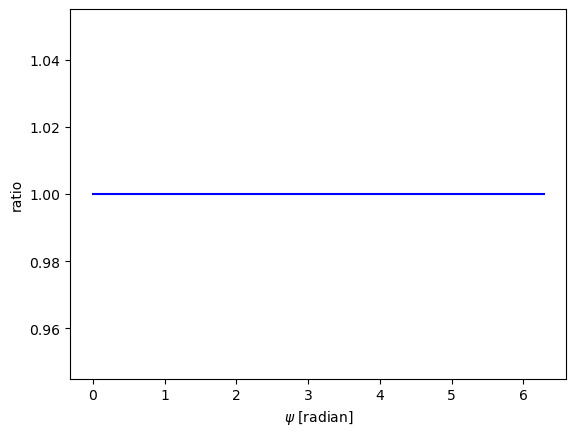

In [302]:
plt.plot(psi,my_snr_/bilby_snr_, color='blue')  
plt.xlabel(r"$\psi$ [radian]")
plt.ylabel(r"ratio")
plt.show()

* psi doesn't have significant effect 
* at random parameters except sky-location, my_snr is exactly same as bilby_snr

# sky location variation 
* check whether the half scled snr vary with ra,dec
* sky location will also vary with geocent time, i keep it fixed
* Fp,Fc depends on sky location
* keep iota=0

In [294]:
# initialized data sample
nsamples = 5
chirp_mass = np.linspace(10,100,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2

# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
geocent_time = 1246527184.169434
ra, dec, psi, phase = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [295]:
'''interpolation_table(q,iota,mchirp_min, mchirp_max, nsamples, psi, phase, ra, dec, geocent_time, \
                        waveform_arguments= dict(waveform_approximant = "TaylorF2", \
                                               reference_frequency = 50., minimum_frequency = 20))'''
    
table1 = interpolation_table(1.,0., 10, 60, 30, 0, 0, ra[0], dec[0], geocent_time, \
                               waveform_arguments= dict(waveform_approximant = "TaylorF2", \
                                                       reference_frequency = 50., minimum_frequency = 20))

In [296]:
table2 = interpolation_table(1.,0., 10, 60, 30, 0, 0, ra[1], dec[1], geocent_time, \
                               waveform_arguments= dict(waveform_approximant = "TaylorF2", \
                                                       reference_frequency = 50., minimum_frequency = 20))

In [297]:
table3 = interpolation_table(1.,0., 10, 60, 30, 0, 0, ra[2], dec[2], geocent_time, \
                               waveform_arguments= dict(waveform_approximant = "TaylorF2", \
                                                       reference_frequency = 50., minimum_frequency = 20))

In [298]:
table4 = interpolation_table(1.,0., 10, 60, 30, 0, 0, ra[3], dec[3], geocent_time, \
                               waveform_arguments= dict(waveform_approximant = "TaylorF2", \
                                                       reference_frequency = 50., minimum_frequency = 20))

In [299]:
table5 = interpolation_table(1.,0., 10, 60, 30, 0, 0, ra[4], dec[4], geocent_time, \
                               waveform_arguments= dict(waveform_approximant = "TaylorF2", \
                                                       reference_frequency = 50., minimum_frequency = 20))

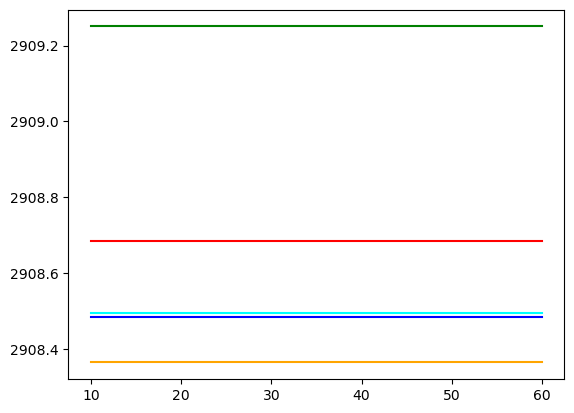

In [300]:
plt.plot(table1[1],table1[2], color='red' ) # ra=2.55812342,dec=2.0774328
plt.plot(table2[1],table2[2], color='blue' ) # ra=5.62792797,dec=1.57003866
plt.plot(table3[1],table3[2], color='green' ) # ra=0.57135829,dec=1.39815471
plt.plot(table4[1],table4[2], color='orange' )
plt.plot(table5[1],table5[2], color='cyan' )

* the difference is very small
* i am ingnoring it

In [215]:
# my_snr vs bilby_snr 
nn = 50
ii = np.random.uniform(0.01,np.pi,size=nn)
chirp_mass_ = np.linspace(50,60,nn)
mass_ratio_ = np.random.uniform(0.2,1,size=nn)
mass_1_ = (chirp_mass_*(1+mass_ratio_)**(1/5))/mass_ratio_**(3/5)
mass_2_ = chirp_mass_*mass_ratio_**(2/5)*(1+mass_ratio_)**(1/5)
psi, phase = np.random.uniform(0,2*np.pi, size=nn), np.random.uniform(0,2*np.pi, size=nn)
ra, dec = np.random.uniform(0,2*np.pi, size=nn), np.random.uniform(0,np.pi, size=nn)
my_snr_ = []
bilby_snr_ = []

for j in range(nn):
    snr_ = scaled_snr_(mm1, mm2, ii[j], 100., psi[j], 1246527184.169434, ra[j], dec[j])
    my_snr_.append(snr_[2]) # L1 only
    snr_ = compute_bilby_snr_(mm1, mm2, 100., ii[j], psi[j], phase[j], 1246527184.169434, ra[j], dec[j], duration=16., sampling_frequency=4096, \
                                          waveform_arguments= dict(waveform_approximant = "TaylorF2", \
                                                                                       reference_frequency = 50., \
                                                                                       minimum_frequency = 20))
    bilby_snr_.append(snr_[0])
    
my_snr_ = np.array(my_snr_)
bilby_snr_ = np.array(bilby_snr_)

In [306]:
nn = 50
ii = 0.
chirp_mass_ = np.random.uniform(10,100,size=nn)
mass_ratio_ = np.random.uniform(0.2,1,size=nn)
mass_1_ = (chirp_mass_*(1+mass_ratio_)**(1/5))/mass_ratio_**(3/5)
mass_2_ = chirp_mass_*mass_ratio_**(2/5)*(1+mass_ratio_)**(1/5)
psi = np.random.uniform(0,2*np.pi, size=nn)
phase = np.random.uniform(0.01,np.pi, size=nn)
ra, dec = np.linspace(0.01,2*np.pi, nn), 0.
my_snr_ = []
bilby_snr_ = []

for j in range(nn):
    snr_ = scaled_snr_(mm1, mm2, ii, 100., psi[j], 1246527184.169434, ra[j], dec)
    my_snr_.append(snr_[2]) # L1 only
    snr_ = compute_bilby_snr_(mm1, mm2, 100., ii, psi[j], phase[j], 1246527184.169434, ra[j], dec, duration=16., sampling_frequency=4096, \
                                          waveform_arguments= dict(waveform_approximant = "TaylorF2", \
                                                                                       reference_frequency = 50., \
                                                                                       minimum_frequency = 20))
    bilby_snr_.append(snr_[0,0])
    
my_snr_ = np.array(my_snr_)
bilby_snr_ = np.array(bilby_snr_)

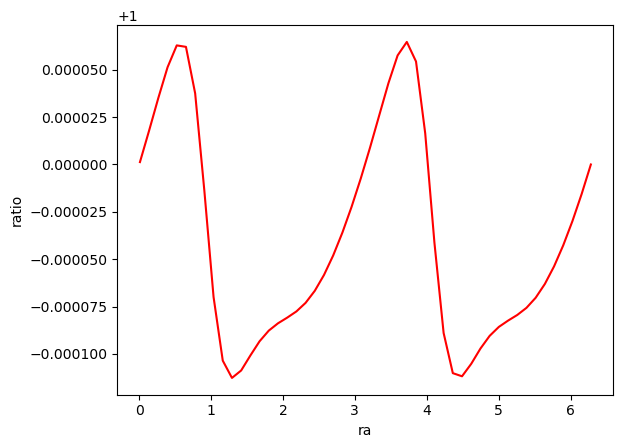

In [307]:
plt.plot(ra,my_snr_/bilby_snr_, color='red')    
plt.xlabel(r"ra")
plt.ylabel(r"ratio")
plt.show()

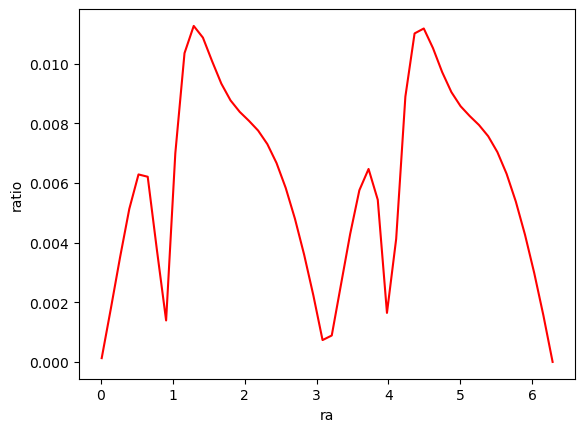

In [308]:
plt.plot(ra,abs(my_snr_-bilby_snr_)/bilby_snr_*100, color='red')    
plt.xlabel(r"ra")
plt.ylabel(r"ratio")
plt.show()

In [309]:
nn = 50
ii = 0.
chirp_mass_ = np.random.uniform(10,100,size=nn)
mass_ratio_ = np.random.uniform(0.2,1,size=nn)
mass_1_ = (chirp_mass_*(1+mass_ratio_)**(1/5))/mass_ratio_**(3/5)
mass_2_ = chirp_mass_*mass_ratio_**(2/5)*(1+mass_ratio_)**(1/5)
psi = np.random.uniform(0,2*np.pi, size=nn)
phase = np.random.uniform(0.01,np.pi, size=nn)
ra, dec = 0., np.linspace(0.01,np.pi, nn)
my_snr_ = []
bilby_snr_ = []

for j in range(nn):
    snr_ = scaled_snr_(mm1, mm2, ii, 100., psi[j], 1246527184.169434, ra, dec[j])
    my_snr_.append(snr_[2]) # L1 only
    snr_ = compute_bilby_snr_(mm1, mm2, 100., ii, psi[j], phase[j], 1246527184.169434, ra, dec[j], duration=16., sampling_frequency=4096, \
                                          waveform_arguments= dict(waveform_approximant = "TaylorF2", \
                                                                                       reference_frequency = 50., \
                                                                                       minimum_frequency = 20))
    bilby_snr_.append(snr_[0,0])
    
my_snr_ = np.array(my_snr_)
bilby_snr_ = np.array(bilby_snr_)

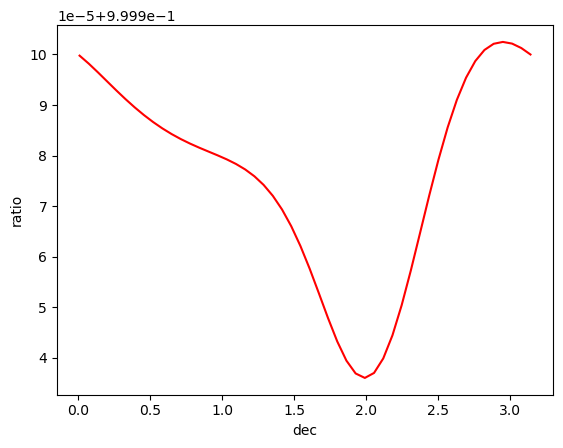

In [311]:
plt.plot(dec,my_snr_/bilby_snr_, color='red')    
plt.xlabel(r"dec")
plt.ylabel(r"ratio")
plt.show()

# scaling_snr Vs bilby_snr with all parameters variation

In [91]:
# checking for array input
scaled_snr_(np.array([10,20,30]), np.array([10,20,30]), np.array([0.,np.pi/6,np.pi/4]), 100., 0., 1246527184.169434, 0., 0.)


array([[ 20.        ,  40.        ,  60.        ],
       [  8.70550563,  17.41101127,  26.1165169 ],
       [142.44857609, 221.71998066, 264.46796881],
       [ 90.37422302, 140.43559325, 166.25845269],
       [ 42.71781044,  66.02000688,  76.16043041],
       [174.02272365, 270.62990778, 321.53629776]])

In [311]:
# initialized data sample
# fixing all parameters except mass1 and mass2
nsamples = 30
chirp_mass = np.linspace(10,150,nsamples)
mass_ratio = 1.*np.ones(nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2

# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = 0.*np.ones(nsamples)
ra, dec, psi, phase, geocent_time = 0.*np.ones(nsamples), 0.*np.ones(nsamples), 0.*np.ones(nsamples), 0.*np.ones(nsamples), 1246527184.169434*np.ones(nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [89]:
my_snrs = []
bilby_snrs = []
for i in range(nsamples):
    snr_ = scaled_snr_(mass_1[i], mass_2[i], theta_jn[i], luminosity_distance[i], psi[i], geocent_time[i], ra[i], dec[i])
    my_snrs.append([snr_[2],snr_[3],snr_[4],snr_[5]])

    
    snr_ = compute_bilby_snr_(mass_1[i], mass_2[i], luminosity_distance[i], theta_jn[i], \
                      psi[i], phase[i], geocent_time[i], ra[i], dec[i] )
    bilby_snrs.append([snr_[0,0],snr_[1,0],snr_[2,0],snr_[3,0]])
    
my_snrs = np.array(my_snrs)
bilby_snrs = np.array(bilby_snrs)

In [ ]:
my_snrs = []
bilby_snrs = []
for i in range(nsamples):
    snr_ = scaled_snr_(mass_1[i], mass_2[i], theta_jn[i], luminosity_distance[i], psi[i], geocent_time[i], ra[i], dec[i])
    my_snrs.append([snr_[2],snr_[3],snr_[4],snr_[5]])

    
    snr_ = compute_bilby_snr_(mass_1[i], mass_2[i], luminosity_distance[i], theta_jn[i], \
                      psi[i], phase[i], geocent_time[i], ra[i], dec[i] )
    bilby_snrs.append([snr_[0,0],snr_[1,0],snr_[2,0],snr_[3,0]])
    
my_snrs = np.array(my_snrs)
bilby_snrs = np.array(bilby_snrs)

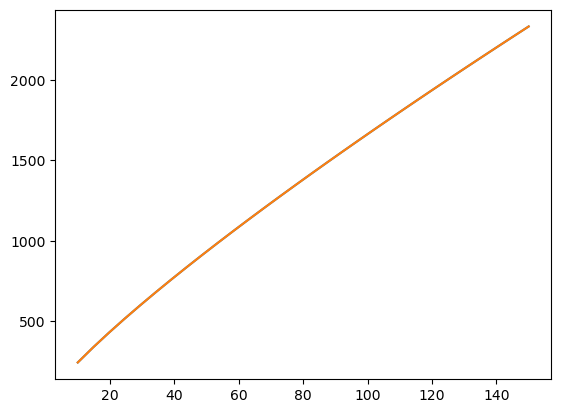

In [90]:
# net snr
plt.plot(chirp_mass,my_snrs[:,3])
plt.plot(chirp_mass,bilby_snrs[:,3])

In [355]:
# gerneral case, random parameters
nsamples = 100
chirp_mass = np.linspace(10,100,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
mass_ratio = mass_2/mass_1
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase, geocent_time = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(12933,1529132, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [356]:
# note the time for 100 points calculation
# if for loop is avoided it will be much more faster
start_time = datetime.now()
my_snrs = []
for i in range(nsamples):
    snr_ = scaled_snr_(mass_1[i], mass_2[i], theta_jn[i], luminosity_distance[i], psi[i], geocent_time[i], ra[i], dec[i])
    my_snrs.append([snr_[2],snr_[3],snr_[4],snr_[5]])
my_snrs = np.array(my_snrs)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:01.401457


* for a milllion point, 13770s = 3hr 49min 30s

In [357]:
start_time = datetime.now()
bilby_snrs = []
for i in range(nsamples):
    snr_ = compute_bilby_snr_(mass_1[i], mass_2[i], luminosity_distance[i], theta_jn[i], \
                      psi[i], phase[i], geocent_time[i], ra[i], dec[i] )
    bilby_snrs.append([snr_[0,0],snr_[1,0],snr_[2,0],snr_[3,0]])
bilby_snrs = np.array(bilby_snrs)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:05.651635


In [347]:
start_time = datetime.now()
bilby_snrs = []
for i in range(nsamples):
    snr_ = compute_bilby_snr_(mass_1[i], mass_2[i], luminosity_distance[i], theta_jn[i], \
                      psi[i], phase[i], geocent_time[i], ra[i], dec[i], duration=16.0, sampling_frequency=4096, \
                      waveform_arguments=  dict(waveform_approximant = "IMRPhenomXPHM", reference_frequency = 30., \
                                                minimum_frequency = 20) )
    bilby_snrs.append([snr_[0,0],snr_[1,0],snr_[2,0],snr_[3,0]])
bilby_snrs = np.array(bilby_snrs)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:07.391210


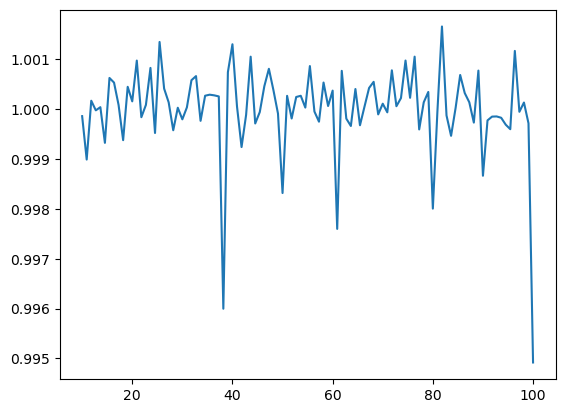

In [358]:
# net snr
plt.plot(chirp_mass,my_snrs[:,3]/bilby_snrs[:,3])

In [ ]:
# with otto's bilby_snr
start_time = datetime.now()
bilby_snrs = []
for i in range(nsamples):
    snr_ = compute_bilby_snr(mass_1[i], mass_2[i], a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, \
                             luminosity_distance[i], theta_jn[i], psi[i], phase[i], geocent_time[i], ra[i], \
                             dec[i], duration=16, sampling_frequency=4096, \
                             waveform_arguments= dict(waveform_approximant = "TaylorF2", reference_frequency = 30., \
                                                      minimum_frequency = 20), \
                             list_of_detectors=["L1", "H1", "V1"])
    bilby_snrs.append(snr_)
bilby_snrs = np.array(bilby_snrs)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:07.003759


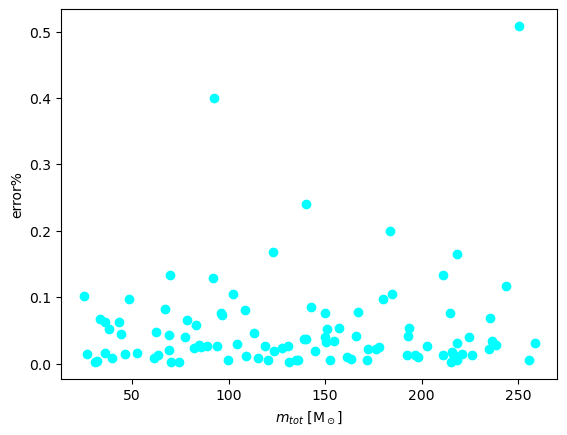

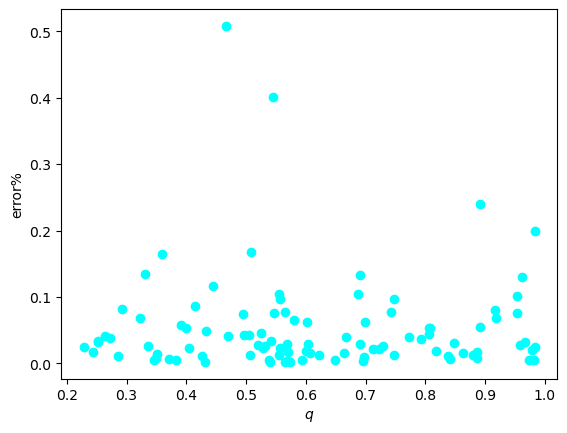

In [359]:
# Compare the net SNRs
# Plot the relative difference (percentage error)
plt.plot(total_mass, np.abs(bilby_snrs[:,3]-my_snrs[:,3])/bilby_snrs[:,3]*100, 'o', color='cyan')
plt.xlabel(r"$m_{tot}$ [$\rm M_\odot$]")
plt.ylabel(r"error%")
plt.show()
plt.plot(mass_ratio, np.abs(bilby_snrs[:,3]-my_snrs[:,3])/bilby_snrs[:,3]*100, 'o', color='cyan')
plt.xlabel(r"$q$")
plt.ylabel(r"error%")
plt.show()

* only 0.5% error

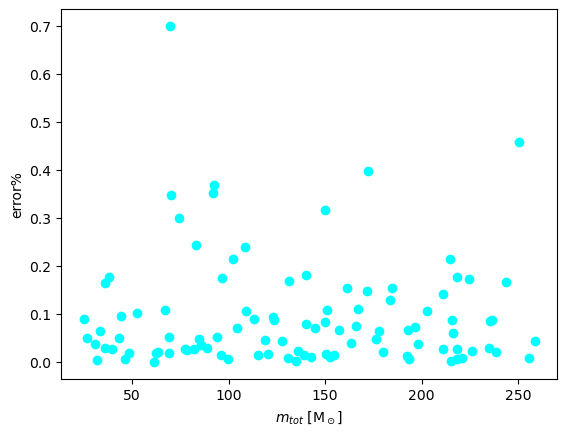

In [360]:
# Compare the L1 SNRs
# Plot the relative difference (percentage error)
plt.plot(total_mass, np.abs(bilby_snrs[:,0]-my_snrs[:,0])/bilby_snrs[:,0]*100, 'o', color='cyan')
plt.xlabel(r"$m_{tot}$ [$\rm M_\odot$]")
plt.ylabel(r"error%")
plt.show()

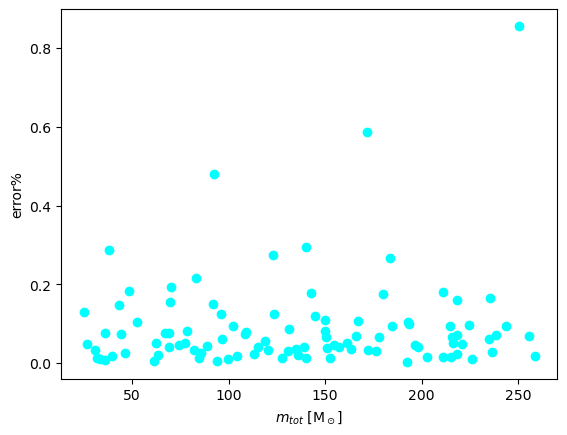

In [361]:
# Compare the H1 SNRs
# Plot the relative difference (percentage error)
plt.plot(total_mass, np.abs(bilby_snrs[:,1]-my_snrs[:,1])/bilby_snrs[:,1]*100, 'o', color='cyan')
plt.xlabel(r"$m_{tot}$ [$\rm M_\odot$]")
plt.ylabel(r"error%")
plt.show()

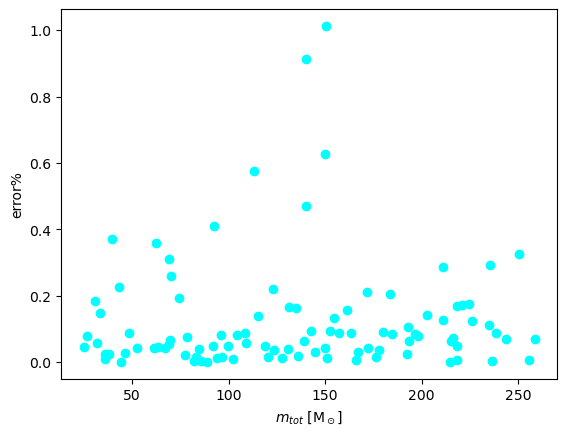

In [362]:
# Compare the V1 SNRs
# Plot the relative difference (percentage error)
plt.plot(total_mass, np.abs(bilby_snrs[:,2]-my_snrs[:,2])/bilby_snrs[:,2]*100, 'o', color='cyan')
plt.xlabel(r"$m_{tot}$ [$\rm M_\odot$]")
plt.ylabel(r"error%")
plt.show()

* individual error can go upto 1%

In [363]:
# from net snr results 
idx = np.abs(bilby_snrs[:,3]-my_snrs[:,3])/bilby_snrs[:,3]*100<0.2
print('total number of points =', len(total_mass))
print('number of points below 0.2% error=', len(total_mass[idx]))

total number of points = 100
number of points below 0.2% error= 97


In [364]:
# what the outlier points look like (net snr case)
idx = np.abs(bilby_snrs[:,3]-my_snrs[:,3])/bilby_snrs[:,3]*100>0.2
print('Mtot: ', total_mass[idx])
print('q: ', mass_ratio[idx])
print('iota: ', theta_jn[idx])
print('psi: ', psi[idx])
print('ra: ', ra[idx])
print('cos(ra): ', np.cos(ra[idx]))
print('dec: ', dec[idx])
print('cos(dec): ', np.cos(dec[idx]))

Mtot:  [ 92.6156997  140.20690671 250.22029434]
q:  [0.5453431  0.89194937 0.46603282]
iota:  [1.67174675 4.61831246 1.53083421]
psi:  [4.56634994 4.93376668 5.51497594]
ra:  [4.44028646 1.54107687 3.75223666]
cos(ra):  [-0.26875719  0.02971509 -0.81927892]
dec:  [1.9948711 1.7868707 0.9195127]
cos(dec):  [-0.41147768 -0.21439694  0.60620778]


* it doesn't follow a pattern

### to find the relation between error and $\omega$
* omega from https://arxiv.org/pdf/1405.7016.pdf eqn (A1)

In [372]:
from pycbc.detector import Detector

In [376]:
Detector('L1').antenna_pattern(ra[1], dec[1], psi[1], 1246527184.169434)

(-0.42822383327026486, -0.39129365752806317)

In [377]:
omega = []
for j in range(nsamples):
    Fp, Fc = Detector('L1').antenna_pattern(ra[j], dec[j], psi[j], 1246527184.169434)
    omega_ = 0.5*(Fp**2 * (1+np.cos(theta_jn[j]))**2 + 4*Fc**2 * np.cos(theta_jn[j])**2 )
    omega.append(omega_)
    
omega = np.array(omega)

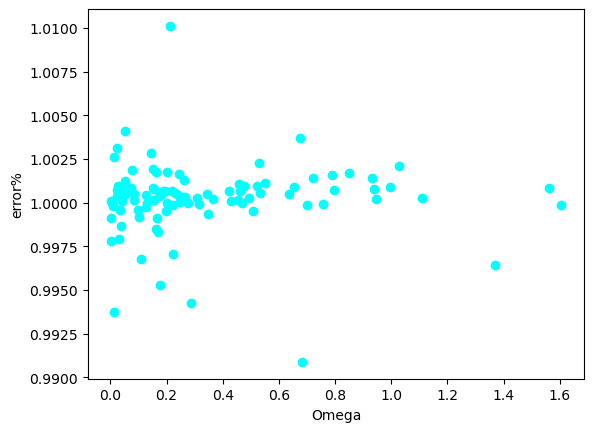

In [382]:
plt.plot(omega, my_snrs[:,2]/bilby_snrs[:,2], 'o', color='cyan')
plt.xlabel(r"Omega")
plt.ylabel(r"error%")
plt.show()

In [ ]:
* no 

# Same test, iota const now

In [350]:
# gerneral case, random parameters
nsamples = 100
chirp_mass = np.linspace(10,100,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
mass_ratio = mass_2/mass_1
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = 0.*np.ones(nsamples)
ra, dec, psi, phase, geocent_time = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(12933,1529132, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [351]:
my_snrs = []
bilby_snrs = []
for i in range(nsamples):
    snr_ = scaled_snr_(mass_1[i], mass_2[i], theta_jn[i], luminosity_distance[i], psi[i], geocent_time[i], ra[i], dec[i])
    my_snrs.append([snr_[2],snr_[3],snr_[4],snr_[5]])

    
    snr_ = compute_bilby_snr_(mass_1[i], mass_2[i], luminosity_distance[i], theta_jn[i], \
                      psi[i], phase[i], geocent_time[i], ra[i], dec[i] )
    bilby_snrs.append([snr_[0,0],snr_[1,0],snr_[2,0],snr_[3,0]])
    
my_snrs = np.array(my_snrs)
bilby_snrs = np.array(bilby_snrs)

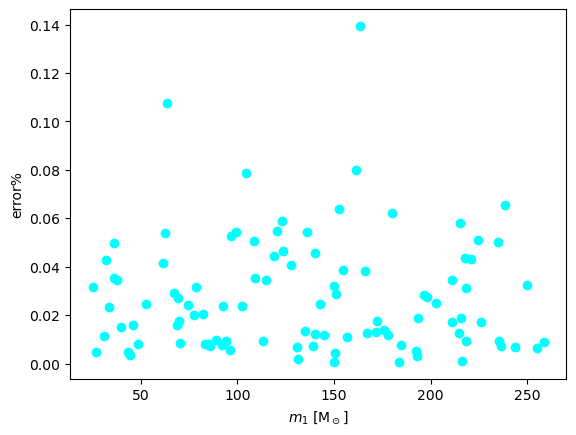

In [352]:
# Compare the SNRs
# Plot the relative difference (percentage error)
plt.plot(total_mass, np.abs(bilby_snrs[:,3]-my_snrs[:,3])/bilby_snrs[:,3]*100, 'o', color='cyan')
plt.xlabel(r"$m_1$ [$\rm M_\odot$]")
plt.ylabel(r"error%")
plt.show()

* if iota is fixed, error comes down from 0.5% to 0.14%

In [433]:
# Sky location fixed
nsamples = 100
chirp_mass = np.linspace(10,100,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
mass_ratio = mass_2/mass_1
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase, geocent_time = 0*np.ones(nsamples), 0*np.ones(nsamples), 0*np.ones(nsamples), \
                                    0*np.ones(nsamples), 1246527184.169434*np.ones(nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [434]:
my_snrs = []
bilby_snrs = []
for i in range(nsamples):
    snr_ = scaled_snr_(mass_1[i], mass_2[i], theta_jn[i], luminosity_distance[i], psi[i], geocent_time[i], ra[i], dec[i])
    my_snrs.append([snr_[2],snr_[3],snr_[4],snr_[5]])

    
    snr_ = compute_bilby_snr_(mass_1[i], mass_2[i], luminosity_distance[i], theta_jn[i], \
                      psi[i], phase[i], geocent_time[i], ra[i], dec[i] )
    bilby_snrs.append([snr_[0,0],snr_[1,0],snr_[2,0],snr_[3,0]])
    
my_snrs = np.array(my_snrs)
bilby_snrs = np.array(bilby_snrs)

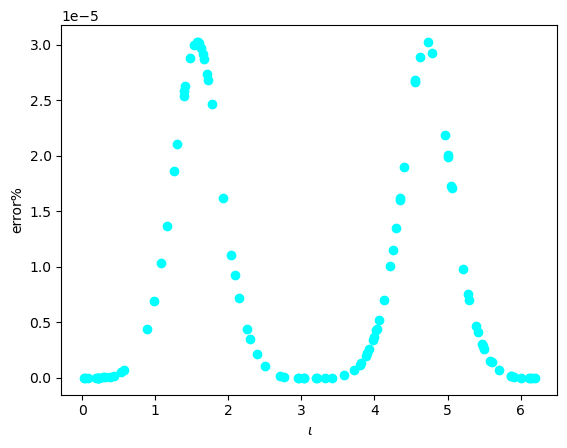

In [437]:
plt.plot(theta_jn, np.abs(bilby_snrs[:,3]-my_snrs[:,3])/bilby_snrs[:,3], 'o', color='cyan')
plt.xlabel(r"$\iota$")
plt.ylabel(r"error%")
plt.show()

# sky location dependence

In [312]:
# gerneral case, random parameters
nsamples = 20
chirp_mass = 60.
mass_ratio = 1.
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
mass_ratio = mass_2/mass_1
# Fix luminosity distance
luminosity_distance = 80
# Randomly sample everything else:
theta_jn = 0.
ra, dec = np.linspace(0,2*np.pi, nsamples), np.linspace(0,np.pi, nsamples)
psi, phase, geocent_time = 0., 0., 1246527184.169434
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [317]:
# bilby_snrs/my_snrs: L1 detector
def func(ra_,dec_):
    ratio = []
    for ii in range(nsamples):
        ratio_ = []
        for jj in range(nsamples):
            my_snrs = scaled_snr_(mass_1, mass_2, theta_jn, luminosity_distance, psi, geocent_time, ra_[ii,jj], dec_[ii,jj])

            bilby_snrs = compute_bilby_snr_(mass_1, mass_2, luminosity_distance, theta_jn, \
                              psi, phase, geocent_time, ra_[ii,jj], dec_[ii,jj] )
            ratio_.append(bilby_snrs[0,0]/my_snrs[2])
        ratio.append(ratio_)
    return(np.array(ratio))

In [314]:
# bilby_snrs: L1 detector
def func(ra_,dec_):
    snr = []
    for ii in range(nsamples):
        snr_ = []
        for jj in range(nsamples):
            bilby_snrs = compute_bilby_snr_(mass_1, mass_2, luminosity_distance, theta_jn, \
                              psi, phase, geocent_time, ra_[ii,jj], dec_[ii,jj] )
            snr_.append(bilby_snrs[0,0])
        snr.append(snr_)
    return(np.array(snr))

In [318]:
xlist = ra
ylist = dec
X, Y = np.meshgrid(xlist, ylist)
Z = func(X,Y)

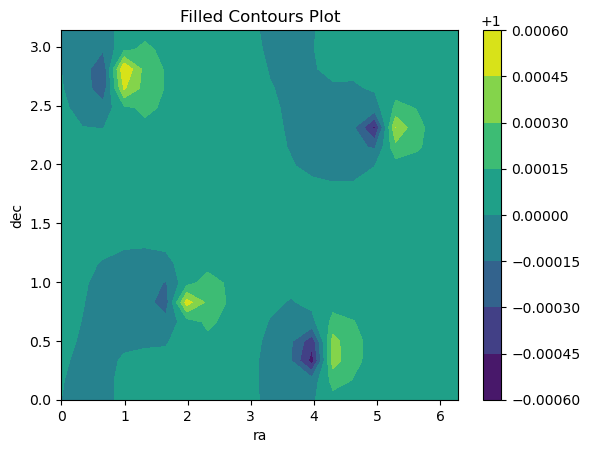

In [319]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_xlabel('ra')
ax.set_ylabel('dec')
plt.show()

* this concludes, iota dependence changes acording to the sky location
* I have also tested with $\iota$ fixed and ra and dec random; but there is no clear pattern on SNR and sky location dependence 
* it will be impossible to add iota correction
* as you can see from the above graph, percentage error is negligible

# below shows iota effect is negligible at optimal sky location case
* taking care of iota effect on $\rho_{1/2}$ for net_snr

In [262]:
# net_snr test
# vary iota
nn = 50
ii = np.linspace(0.01,np.pi,nn)
chirp_mass_ = 81.37931034
mass_ratio_ = 0.56807095
mass_1_ = (chirp_mass_*(1+mass_ratio_)**(1/5))/mass_ratio_**(3/5)
mass_2_ = chirp_mass_*mass_ratio_**(2/5)*(1+mass_ratio_)**(1/5)
my_snr_ = []
bilby_snr_ = []

for j in range(nn):
    snr_ = scaled_snr_(mm1, mm2, ii[j], 80., 0., 1246527184.169434, 0., 0.)
    my_snr_.append(snr_) # L1 only
    snr_ = compute_bilby_snr_(mm1, mm2, 80., ii[j], 0., 0., 1246527184.169434, 0., 0., duration=16., sampling_frequency=4096, \
                                          waveform_arguments= dict(waveform_approximant = "TaylorF2", \
                                                                                       reference_frequency = 30., \
                                                                                       minimum_frequency = 20))
    bilby_snr_.append([snr_[0,0],snr_[1,0],snr_[2,0],snr_[3,0]] )
    
my_snr_ = np.array(my_snr_)
bilby_snr_ = np.array(bilby_snr_)

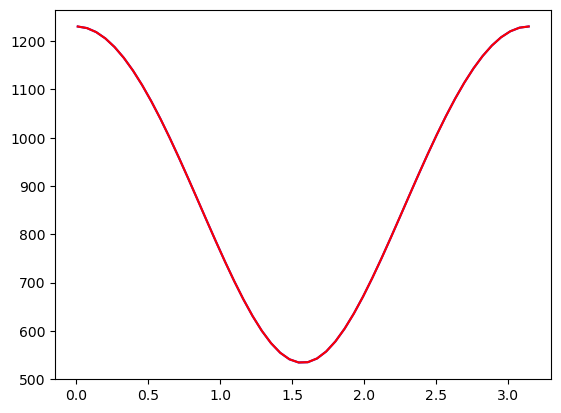

In [264]:
# net snr
plt.plot(ii,my_snr_[:,5], color='blue')
plt.plot(ii,bilby_snr_[:,3], color='red')

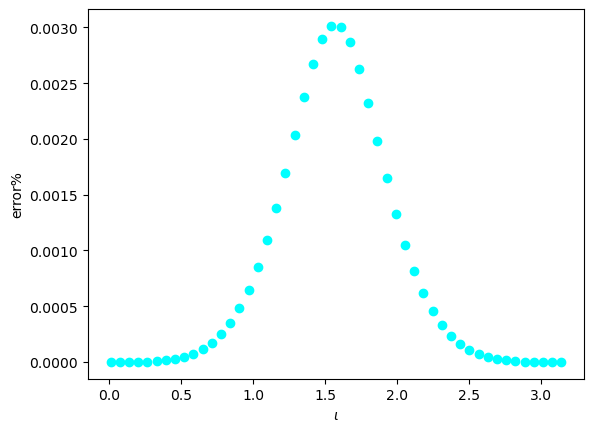

In [265]:
# Compare the SNRs
# Plot the relative difference (percentage error)
plt.plot(ii, np.abs(bilby_snr_[:,3]-my_snr_[:,5])/bilby_snr_[:,3]*100, 'o', color='cyan')
plt.xlabel(r"$\iota$")
plt.ylabel(r"error%")
plt.show()

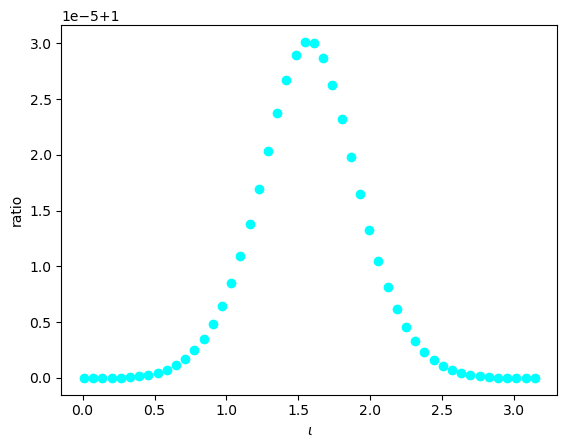

In [266]:
plt.plot(ii, bilby_snr_[:,3]/my_snr_[:,5], 'o', color='cyan')
plt.xlabel(r"$\iota$")
plt.ylabel(r"ratio")
plt.show()

* only 0.003% error

In [267]:
# (a,b,c) are params for the fit functional curve
def func(x, a, b, c):
    return a*np.exp(-(x-b)**2/(2*c**2))+1


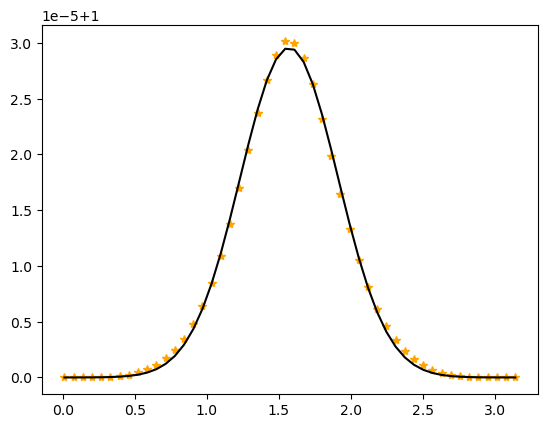

In [270]:
x_ = ii
y_ = bilby_snr_[:,3]/my_snr_[:,5]
param = curve_fit(func, x_, y_)[0]
a,b,c = param[0],param[1],param[2]
plt.plot(x_, y_, '*', color='orange', label='q=0.1')
plt.plot(x_,a*np.exp(-(x_-b)**2/(2*c**2))+1, color='black', label='q=0.1(fit)')

# rewriting scaling func to accomodate varying iota

* iota related scaling only applying on net_snr

In [271]:
param

array([2.95721609e-05, 1.57079653e+00, 3.39696930e-01])

In [272]:
# simplified scaled_snr
# without interpolation table
# considering, half scaled snr is just a line, not affected by chirp_mass and mass_ratio (for TaylorF2) 
def scaled_snr_2(mass_1, mass_2, iota, Dl, psi, geocent_time, ra, dec):
    
    chirp_mass = ( (mass_1*mass_2)**(3/5) )/( (mass_1+mass_2)**(1/5) )
    mtot = mass_2+mass_1
    A1 = chirp_mass**(5./6.)
    geocent_time = geocent_time
    iota_scale = (2.95721609e-05)*np.exp(-(iota-1.57079653)**2/(2*0.339696930**2))+1 # iota in radian [0,2*np.pi]
    # snr_HalfScaled = [2908.2661468129972, 2908.0417461038714, 2214.693865936319]
    # for L1,H1,V1 respectively
    ##############################
    Fp, Fc = Detector('L1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    L1snr_ = (A1/Deff1)*2908.2661468129972
    ##############################
    Fp, Fc = Detector('H1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    H1snr_ =  (A1/Deff1)*2908.0417461038714
    ##############################
    Fp, Fc = Detector('V1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    V1snr_ =  (A1/Deff1)*2214.693865936319
    
    net_snr = np.sqrt(L1snr_**2 + H1snr_**2 + V1snr_**2)*iota_scale
    
    return(np.array( [mtot,chirp_mass,L1snr_,H1snr_,V1snr_,net_snr] ))

In [275]:
# return(np.array([opt_snr0, opt_snr1, opt_snr2, opt_snr_net]))
nn = 50
ii = np.linspace(0.01,np.pi,nn)
chirp_mass_ = np.linspace(10,100,nn)
mass_ratio_ = np.random.uniform(0.2,1,size=nn)
mass_1_ = (chirp_mass_*(1+mass_ratio_)**(1/5))/mass_ratio_**(3/5)
mass_2_ = chirp_mass_*mass_ratio_**(2/5)*(1+mass_ratio_)**(1/5)
my_snr_ = []
bilby_snr_ = []

for j in range(nn):
    snr_ = scaled_snr_2(mm1, mm2, ii[j], 100., 0., 1246527184.169434, 0., 0.)
    my_snr_.append(snr_[5]) # L1 only
    snr_ = compute_bilby_snr_(mm1, mm2, 100., ii[j], 0., 0., 1246527184.169434, 0., 0., duration=16., sampling_frequency=4096, \
                                          waveform_arguments= dict(waveform_approximant = "TaylorF2", \
                                                                                       reference_frequency = 50., \
                                                                                       minimum_frequency = 20))
    bilby_snr_.append(snr_[3,0])
    
my_snr_ = np.array(my_snr_)
bilby_snr_ = np.array(bilby_snr_)

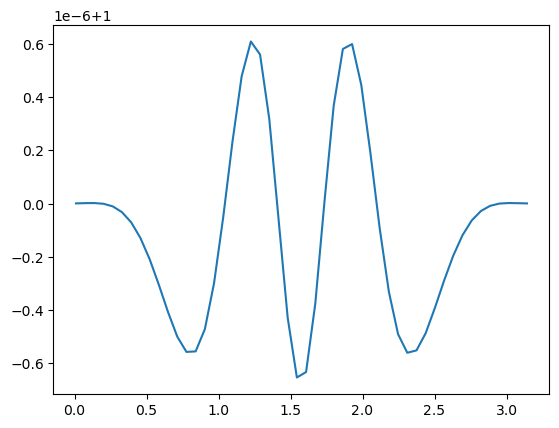

In [276]:
plt.plot(ii,my_snr_/bilby_snr_)

In [280]:
# changing polarization angle
# return(np.array([opt_snr0, opt_snr1, opt_snr2, opt_snr_net]))
nn = 50
ii = 0.
chirp_mass_ = np.linspace(10,100,nn)
mass_ratio_ = np.random.uniform(0.2,1,size=nn)
mass_1_ = (chirp_mass_*(1+mass_ratio_)**(1/5))/mass_ratio_**(3/5)
mass_2_ = chirp_mass_*mass_ratio_**(2/5)*(1+mass_ratio_)**(1/5)
psi = np.linspace(0.01,np.pi, nn)
my_snr_ = []
bilby_snr_ = []

for j in range(nn):
    snr_ = scaled_snr_2(mm1, mm2, ii, 100., psi[j], 1246527184.169434, 0., 0.)
    my_snr_.append(snr_[5]) # L1 only
    snr_ = compute_bilby_snr_(mm1, mm2, 100., ii, psi[j], 0., 1246527184.169434, 0., 0., duration=16., sampling_frequency=4096, \
                                          waveform_arguments= dict(waveform_approximant = "TaylorF2", \
                                                                                       reference_frequency = 50., \
                                                                                       minimum_frequency = 20))
    bilby_snr_.append(snr_[3,0])
    
my_snr_ = np.array(my_snr_)
bilby_snr_ = np.array(bilby_snr_)

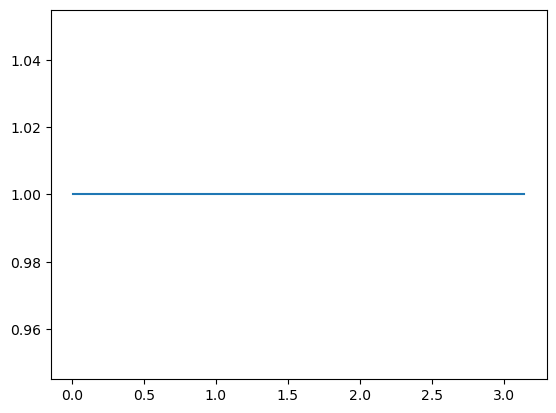

In [282]:
plt.plot(psi,my_snr_/bilby_snr_)

In [277]:
# gerneral case, random parameters
nsamples = 100
chirp_mass = np.linspace(10,100,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
mass_ratio = mass_2/mass_1
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase, geocent_time = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(12933,1529132, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [278]:
my_snrs = []
bilby_snrs = []
for i in range(nsamples):
    snr_ = scaled_snr_2(mass_1[i], mass_2[i], theta_jn[i], luminosity_distance[i], psi[i], geocent_time[i], ra[i], dec[i])
    my_snrs.append([snr_[2],snr_[3],snr_[4],snr_[5]])

    
    snr_ = compute_bilby_snr_(mass_1[i], mass_2[i], luminosity_distance[i], theta_jn[i], \
                      psi[i], phase[i], geocent_time[i], ra[i], dec[i] )
    bilby_snrs.append([snr_[0,0],snr_[1,0],snr_[2,0],snr_[3,0]])
    
my_snrs = np.array(my_snrs)
bilby_snrs = np.array(bilby_snrs)

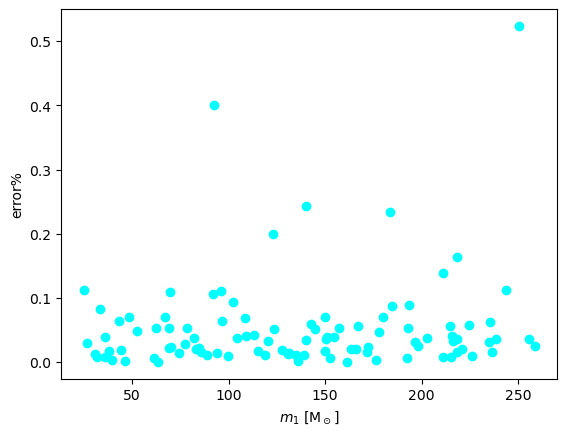

Text(0, 0.5, 'error%')

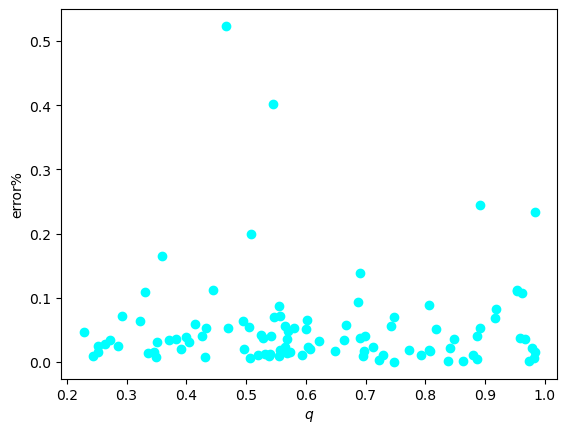

In [279]:
# Compare the net SNRs
# Plot the relative difference (percentage error)
plt.plot(total_mass, np.abs(bilby_snrs[:,3]-my_snrs[:,3])/bilby_snrs[:,3]*100, 'o', color='cyan')
plt.xlabel(r"$m_1$ [$\rm M_\odot$]")
plt.ylabel(r"error%")
plt.show()
plt.plot(mass_ratio, np.abs(bilby_snrs[:,3]-my_snrs[:,3])/bilby_snrs[:,3]*100, 'o', color='cyan')
plt.xlabel(r"$q$")
plt.ylabel(r"error%")

* adding iota effect correction to the half scaled snr has negligible effect at the final vaule

# Conclusion
* For taylorF2, scaling is rather simple, don't even need interpolation 
* my snr calulation is 4.4s$\times$ faster than bilby snr calculation, for 100 parmeter points (~5.3s for IMRPhenomXPHM)
* is it fast enough to consider??

# TaylorF2 Vs IMRPhenomXPHM

In [366]:
# q=1, iota,ra,dec=0,
nsamples = 100
chirp_mass = np.linspace(10,100,nsamples)
mass_ratio = 1.*np.ones(nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
mass_ratio = mass_2/mass_1
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = 0.*np.ones(nsamples)
geocent_time = 1246527184.169434*np.ones(nsamples)
ra, dec, psi, phase = 0.*np.ones(nsamples), 0.*np.ones(nsamples), 0.*np.ones(nsamples), 0.*np.ones(nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [367]:
start_time = datetime.now()
my_snrs = []
for i in range(nsamples):
    snr_ = scaled_snr_(mass_1[i], mass_2[i], theta_jn[i], luminosity_distance[i], psi[i], geocent_time[i], ra[i], dec[i])
    my_snrs.append([snr_[2],snr_[3],snr_[4],snr_[5]])
my_snrs = np.array(my_snrs)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:01.437185


In [372]:
start_time = datetime.now()
bilby_snrs = []
for i in range(nsamples):
    snr_ = compute_bilby_snr_(mass_1[i], mass_2[i], luminosity_distance[i], theta_jn[i], \
                      psi[i], phase[i], geocent_time[i], ra[i], dec[i] )
    bilby_snrs.append([snr_[0,0],snr_[1,0],snr_[2,0],snr_[3,0]])
bilby_snrs = np.array(bilby_snrs)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:07.410554


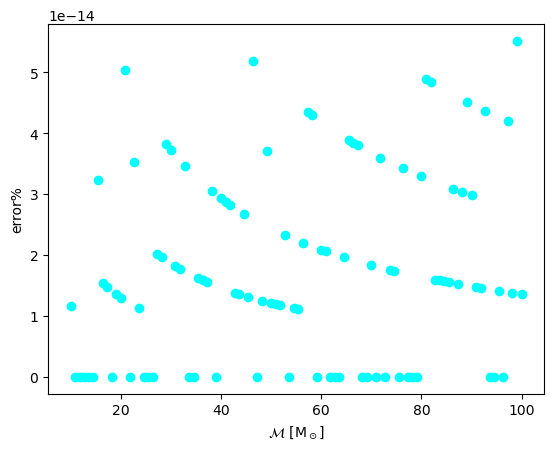

In [374]:
# Compare the SNRs
# Plot the relative difference (percentage error)
plt.plot(chirp_mass, np.abs(bilby_snrs[:,3]-my_snrs[:,3])/bilby_snrs[:,3]*100, 'o', color='cyan')
plt.xlabel(r"$\mathcal{M}$ [$\rm M_\odot$]")
plt.ylabel(r"error%")
plt.show()

In [375]:
start_time = datetime.now()
bilby_snrs = []
for i in range(nsamples):
    snr_ = compute_bilby_snr_(mass_1[i], mass_2[i], luminosity_distance[i], theta_jn[i], \
                      psi[i], phase[i], geocent_time[i], ra[i], dec[i], sampling_frequency=4096, \
                                          waveform_arguments= dict(waveform_approximant = "IMRPhenomXPHM", \
                                                                                       reference_frequency = 30., \
                                                                                       minimum_frequency = 20))
    bilby_snrs.append([snr_[0,0],snr_[1,0],snr_[2,0],snr_[3,0]])
bilby_snrs = np.array(bilby_snrs)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:06.686902


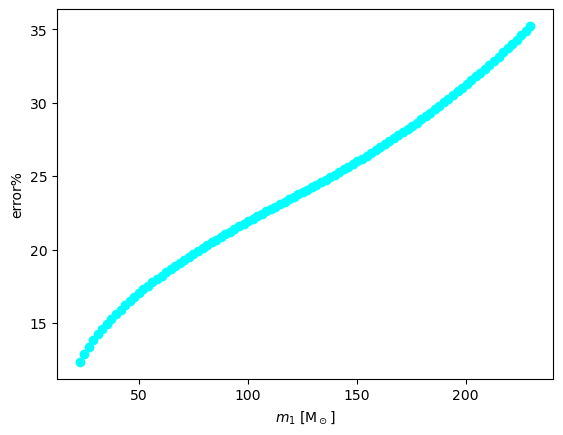

In [376]:
# Compare the SNRs
# Plot the relative difference (percentage error)
plt.plot(total_mass, np.abs(bilby_snrs[:,3]-my_snrs[:,3])/bilby_snrs[:,3]*100, 'o', color='cyan')
plt.xlabel(r"$m_1$ [$\rm M_\odot$]")
plt.ylabel(r"error%")
plt.show()

* taylorF2 to IMRPhenomXPHM interpolation is possible for optimal orientation 

* random orientation and sky location now

In [378]:
# gerneral case, random parameters
nsamples = 100
chirp_mass = np.linspace(10,80,nsamples)
mass_ratio = 1.*np.ones(nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
mass_ratio = mass_2/mass_1
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase, geocent_time = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(12933,1529132, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [379]:
start_time = datetime.now()
my_snrs = []
for i in range(nsamples):
    snr_ = scaled_snr_(mass_1[i], mass_2[i], theta_jn[i], luminosity_distance[i], psi[i], geocent_time[i], ra[i], dec[i])
    my_snrs.append([snr_[2],snr_[3],snr_[4],snr_[5]])
my_snrs = np.array(my_snrs)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:01.679084


In [380]:
start_time = datetime.now()
bilby_snrs = []
for i in range(nsamples):
    snr_ = compute_bilby_snr_(mass_1[i], mass_2[i], luminosity_distance[i], theta_jn[i], \
                      psi[i], phase[i], geocent_time[i], ra[i], dec[i] )
    bilby_snrs.append([snr_[0,0],snr_[1,0],snr_[2,0],snr_[3,0]])
bilby_snrs = np.array(bilby_snrs)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:07.144531


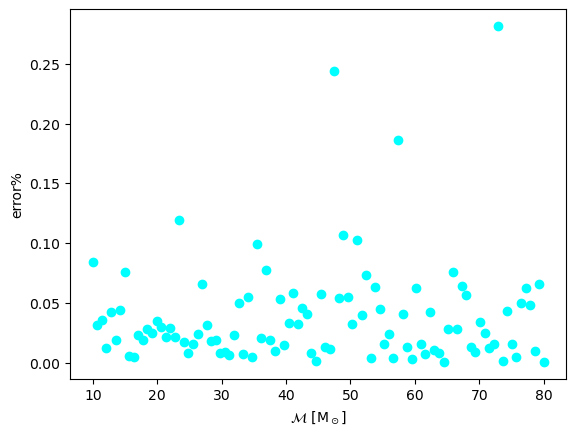

In [381]:
# Compare the SNRs
# Plot the relative difference (percentage error)
plt.plot(chirp_mass, np.abs(bilby_snrs[:,3]-my_snrs[:,3])/bilby_snrs[:,3]*100, 'o', color='cyan')
plt.xlabel(r"$\mathcal{M}$ [$\rm M_\odot$]")
plt.ylabel(r"error%")
plt.show()

In [382]:
start_time = datetime.now()
bilby_snrs = []
for i in range(nsamples):
    snr_ = compute_bilby_snr_(mass_1[i], mass_2[i], luminosity_distance[i], theta_jn[i], \
                      psi[i], phase[i], geocent_time[i], ra[i], dec[i], sampling_frequency=4096, \
                                          waveform_arguments= dict(waveform_approximant = "IMRPhenomXPHM", \
                                                                                       reference_frequency = 30., \
                                                                                       minimum_frequency = 20))
    bilby_snrs.append([snr_[0,0],snr_[1,0],snr_[2,0],snr_[3,0]])
bilby_snrs = np.array(bilby_snrs)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:07.601486


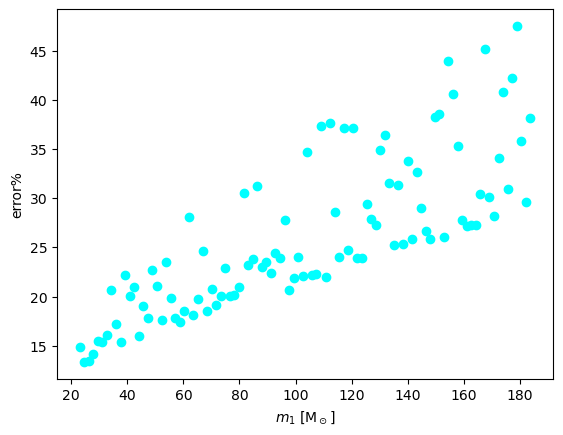

In [383]:
# Compare the SNRs
# Plot the relative difference (percentage error)
plt.plot(total_mass, np.abs(bilby_snrs[:,3]-my_snrs[:,3])/bilby_snrs[:,3]*100, 'o', color='cyan')
plt.xlabel(r"$m_1$ [$\rm M_\odot$]")
plt.ylabel(r"error%")
plt.show()

# Double fitting

* analyze how snr ratio behaves with chirp mass at discrete q points 

In [102]:
def scaled_snr_(mass_1, mass_2, iota, Dl, psi, geocent_time, ra, dec):
    
    chirp_mass = ( (mass_1*mass_2)**(3/5) )/( (mass_1+mass_2)**(1/5) )
    mtot = mass_2+mass_1
    A1 = chirp_mass**(5./6.)
    geocent_time = geocent_time
    # snr_HalfScaled = [2908.2661468129972, 2908.0417461038714, 2214.693865936319]
    # for L1,H1,V1 respectively
    ##############################
    Fp, Fc = Detector('L1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    L1snr_ = (A1/Deff1)*2908.2661468129972
    ##############################
    Fp, Fc = Detector('H1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    H1snr_ =  (A1/Deff1)*2908.0417461038714
    ##############################
    Fp, Fc = Detector('V1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    V1snr_ =  (A1/Deff1)*2214.693865936319
    
    net_snr = np.sqrt(L1snr_**2 + H1snr_**2 + V1snr_**2)
    
    return(np.array( [mtot,chirp_mass,L1snr_,H1snr_,V1snr_,net_snr] ))

In [103]:
# gerneral case, random parameters
nsamples = 50
chirp_mass = np.linspace(10,100,nsamples)
mass_ratio = 0.1*np.ones(nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
mass_ratio = mass_2/mass_1
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = 0.*np.ones(nsamples)
geocent_time = 1246527184.169434*np.ones(nsamples)
ra, dec, psi, phase = 0.*np.ones(nsamples), 0.*np.ones(nsamples), 0.*np.ones(nsamples), 0.*np.ones(nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [104]:
my_snrs1 = []
bilby_snrs1 = []
for i in range(nsamples):
    snr_ = scaled_snr_(mass_1[i], mass_2[i], theta_jn[i], luminosity_distance[i], psi[i], geocent_time[i], ra[i], dec[i])
    my_snrs1.append([snr_[2],snr_[3],snr_[4],snr_[5]])
    snr_ = compute_bilby_snr_(mass_1[i], mass_2[i], luminosity_distance[i], theta_jn[i], \
                      psi[i], phase[i], geocent_time[i], ra[i], dec[i], sampling_frequency=4096, \
                                          waveform_arguments= dict(waveform_approximant = "IMRPhenomXPHM", \
                                                                                       reference_frequency = 30., \
                                                                                       minimum_frequency = 20))
    bilby_snrs1.append([snr_[0,0],snr_[1,0],snr_[2,0],snr_[3,0]])
my_snrs1 = np.array(my_snrs1)
bilby_snrs1 = np.array(bilby_snrs1)

In [53]:
nsamples = 50
chirp_mass = np.linspace(10,100,nsamples)
mass_ratio = 0.31622777*np.ones(nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
mass_ratio = mass_2/mass_1
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = 0.*np.ones(nsamples)
geocent_time = 1246527184.169434*np.ones(nsamples)
ra, dec, psi, phase = 0.*np.ones(nsamples), 0.*np.ones(nsamples), 0.*np.ones(nsamples), 0.*np.ones(nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [54]:
my_snrs2 = []
bilby_snrs2 = []
for i in range(nsamples):
    snr_ = scaled_snr_(mass_1[i], mass_2[i], theta_jn[i], luminosity_distance[i], psi[i], geocent_time[i], ra[i], dec[i])
    my_snrs2.append([snr_[2],snr_[3],snr_[4],snr_[5]])
    snr_ = compute_bilby_snr_(mass_1[i], mass_2[i], luminosity_distance[i], theta_jn[i], \
                      psi[i], phase[i], geocent_time[i], ra[i], dec[i], sampling_frequency=4096, \
                                          waveform_arguments= dict(waveform_approximant = "IMRPhenomXPHM", \
                                                                                       reference_frequency = 30., \
                                                                                       minimum_frequency = 20))
    bilby_snrs2.append([snr_[0,0],snr_[1,0],snr_[2,0],snr_[3,0]])
my_snrs2 = np.array(my_snrs2)
bilby_snrs2 = np.array(bilby_snrs2)

In [55]:
nsamples = 50
chirp_mass = np.linspace(10,100,nsamples)
mass_ratio = 1.*np.ones(nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
mass_ratio = mass_2/mass_1
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = 0.*np.ones(nsamples)
geocent_time = 1246527184.169434*np.ones(nsamples)
ra, dec, psi, phase = 0.*np.ones(nsamples), 0.*np.ones(nsamples), 0.*np.ones(nsamples), 0.*np.ones(nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [56]:
my_snrs3 = []
bilby_snrs3 = []
for i in range(nsamples):
    snr_ = scaled_snr_(mass_1[i], mass_2[i], theta_jn[i], luminosity_distance[i], psi[i], geocent_time[i], ra[i], dec[i])
    my_snrs3.append([snr_[2],snr_[3],snr_[4],snr_[5]])
    snr_ = compute_bilby_snr_(mass_1[i], mass_2[i], luminosity_distance[i], theta_jn[i], \
                      psi[i], phase[i], geocent_time[i], ra[i], dec[i], sampling_frequency=4096, \
                                          waveform_arguments= dict(waveform_approximant = "IMRPhenomXPHM", \
                                                                                       reference_frequency = 30., \
                                                                                       minimum_frequency = 20))
    bilby_snrs3.append([snr_[0,0],snr_[1,0],snr_[2,0],snr_[3,0]])
my_snrs3 = np.array(my_snrs3)
bilby_snrs3 = np.array(bilby_snrs3)

In [58]:
cs1 = CubicSpline(chirp_mass, bilby_snrs1[:,3]/my_snrs1[:,3])
cs2 = CubicSpline(chirp_mass, bilby_snrs2[:,3]/my_snrs2[:,3])
cs3 = CubicSpline(chirp_mass, bilby_snrs3[:,3]/my_snrs3[:,3])

cs = np.array([cs1,cs2,cs3], dtype=object) 

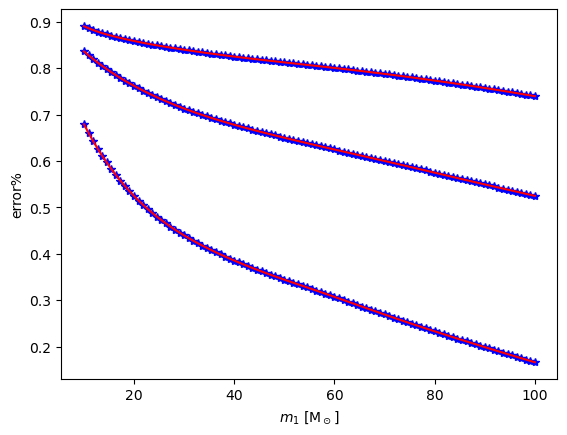

In [59]:
xx = chirp_mass
yy = bilby_snrs1[:,3]/my_snrs1[:,3]
plt.plot(xx, yy , '*',color='blue')
plt.plot(xx, cs[0](xx), color='red')

yy = bilby_snrs2[:,3]/my_snrs2[:,3]
plt.plot(xx, yy , '*',color='blue')
plt.plot(xx, cs[1](xx), color='red')

yy = bilby_snrs3[:,3]/my_snrs3[:,3]
plt.plot(xx, yy , '*',color='blue')
plt.plot(xx, cs[2](xx), color='red')

plt.xlabel(r"$m_1$ [$\rm M_\odot$]")
plt.ylabel(r"error%")
plt.show()

* now find cubic spline fits for 20 q points 

In [106]:
MassRatio = np.geomspace(0.1,1,20)
print(MassRatio)

[0.1        0.11288379 0.1274275  0.14384499 0.16237767 0.18329807
 0.20691381 0.23357215 0.26366509 0.29763514 0.33598183 0.37926902
 0.42813324 0.48329302 0.54555948 0.61584821 0.6951928  0.78475997
 0.88586679 1.        ]


In [107]:
nsamples = 30
chirp_mass = np.linspace(1,100,nsamples)
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = 0.*np.ones(nsamples)
geocent_time = 1246527184.169434*np.ones(nsamples)
ra, dec, psi, phase = 0.*np.ones(nsamples), 0.*np.ones(nsamples), 0.*np.ones(nsamples), 0.*np.ones(nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin
waveform_argument = dict(waveform_approximant = "IMRPhenomXPHM", reference_frequency = 30., minimum_frequency = 20)

In [108]:
start_time = datetime.now()
nn = 20
MassRatio = np.geomspace(0.1,1,nn)
cs = []
for j in range(nn):
    mass_ratio = MassRatio[j]*np.ones(nsamples)
    mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
    mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
    my_snrs3 = []
    bilby_snrs3 = []
    SNR_ratio = []
    for i in range(nsamples):
        my_snrs_ = scaled_snr_(mass_1[i], mass_2[i], theta_jn[i], luminosity_distance[i], psi[i], geocent_time[i], ra[i], dec[i])[5]
        
        bilby_snrs_ = compute_bilby_snr_(mass_1[i], mass_2[i], luminosity_distance[i], theta_jn[i], \
                          psi[i], phase[i], geocent_time[i], ra[i], dec[i], sampling_frequency=4096, \
                                              waveform_arguments=waveform_argument )[3,0]
        SNR_ratio.append(bilby_snrs_/my_snrs_)
    cs.append(np.array(SNR_ratio))
cs = np.array(cs)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:52.511051


In [137]:
chirp_mass[29], MassRatio[19]

(100.0, 1.0)

In [138]:
np.shape(cs)

(20, 30)

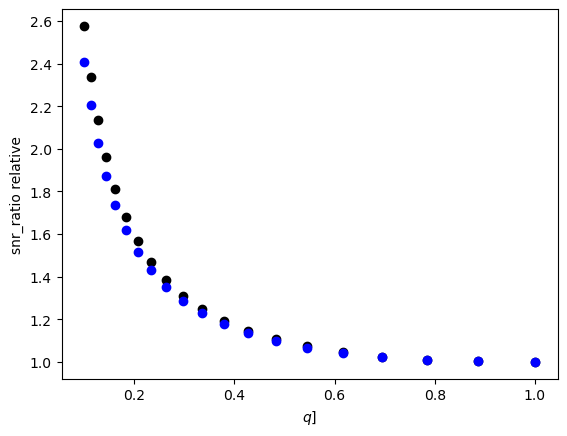

In [141]:
plt.plot(MassRatio, cs[19,17]/cs[:,17], 'o', color='black')
plt.plot(MassRatio, cs[19,15]/cs[:,15], 'o', color='blue')
plt.xlabel(r"$q$]")
plt.ylabel(r"snr_ratio relative")
plt.show()

In [149]:
def func(x, a, b):
    return np.exp(-a*x)*b+1

In [152]:
'''def func(x, a, b, c):
    return -np.log(a*x)*b+c'''

In [161]:
#chirp_mass[29]=100
x_1 = MassRatio
y_1 = cs[19,28]/cs[:,28]
y_2 = cs[19,29]/cs[:,29]
y_3 = cs[19,8]/cs[:,8]
y_4 = cs[19,9]/cs[:,9]

param = [] 
param.append(CubicSpline(x_1, y_1))
param.append(CubicSpline(x_1, y_2))
param.append(CubicSpline(x_1, y_3))
param.append(CubicSpline(x_1, y_4))

param = np.array(param)

In [144]:
chirp_mass[29],chirp_mass[19],chirp_mass[9]

(100.0, 65.86206896551724, 31.724137931034484)

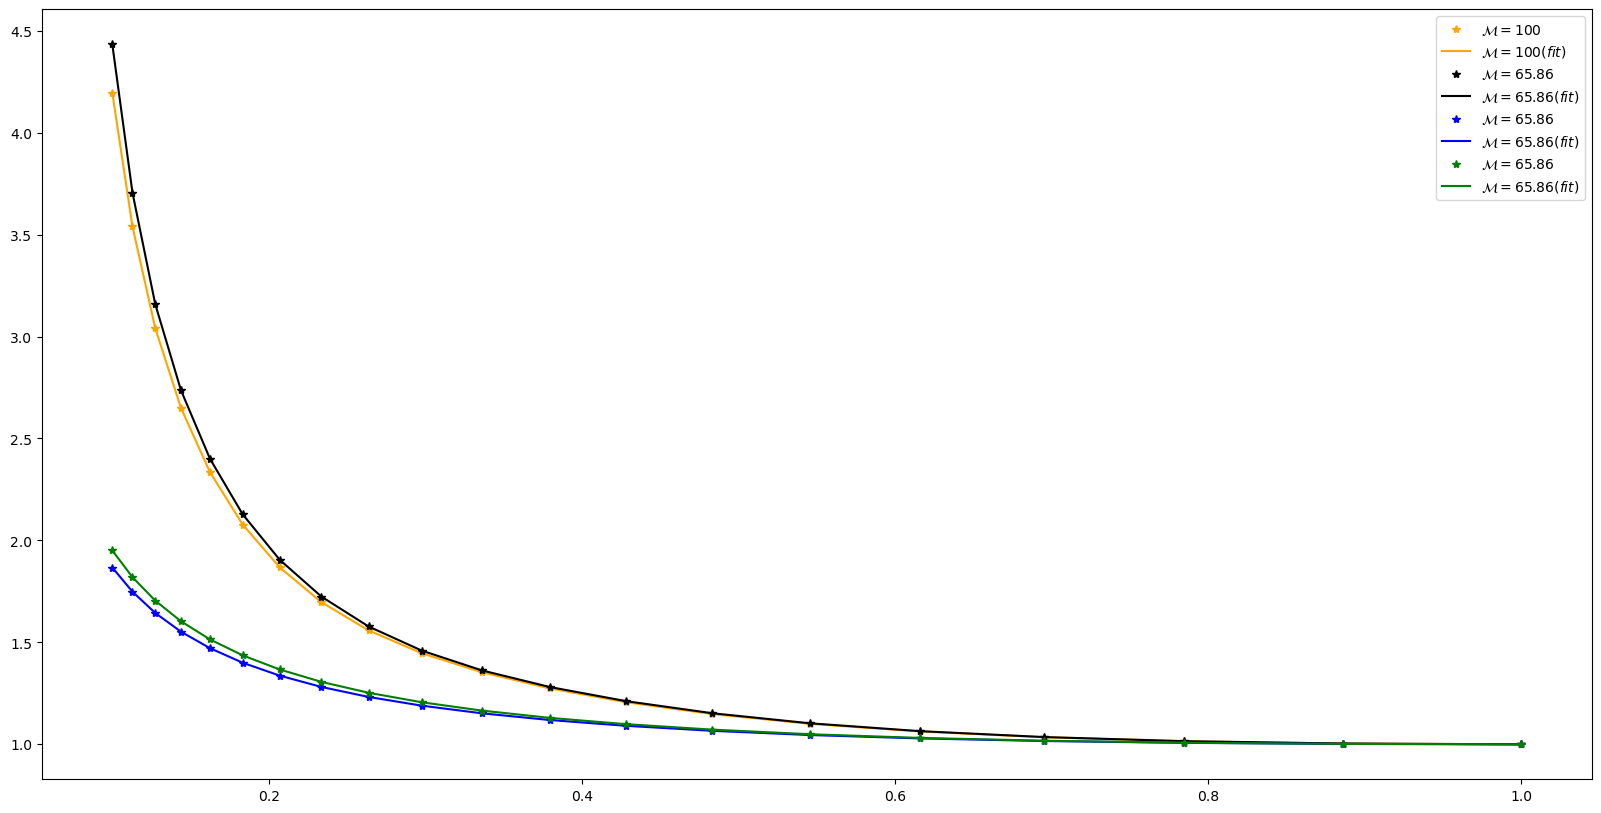

In [164]:
plt.plot(x_1, y_1, '*', color='orange', label='$\mathcal{M}=100$')
plt.plot(x_1, param[0](x_1), color='orange', label='$\mathcal{M}=100(fit)$')
plt.plot(x_1, y_2, '*', color='black', label='$\mathcal{M}=65.86$')
plt.plot(x_1, param[1](x_1), color='black', label='$\mathcal{M}=65.86(fit)$')
plt.plot(x_1, y_3, '*', color='blue', label='$\mathcal{M}=65.86$')
plt.plot(x_1, param[2](x_1), color='blue', label='$\mathcal{M}=65.86(fit)$')
plt.plot(x_1, y_4, '*', color='green', label='$\mathcal{M}=65.86$')
plt.plot(x_1, param[3](x_1), color='green', label='$\mathcal{M}=65.86(fit)$')

plt.legend()
plt.rcParams['figure.figsize'] = [20, 10]
plt.show()

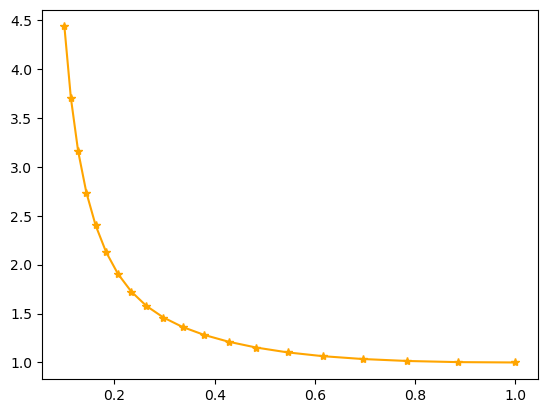

In [159]:
plt.plot(x_1, y_1, '*', color='orange', label='$\mathcal{M}=100$')
plt.plot(x_1, param[0](x_1), color='orange', label='$\mathcal{M}=100(fit)$')

In [64]:
start_time = datetime.now()
nn = 20
MassRatio = np.geomspace(0.1,1,nn)
cs = []
for j in range(nn):
    mass_ratio = MassRatio[j]*np.ones(nsamples)
    mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
    mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
    my_snrs3 = []
    bilby_snrs3 = []
    SNR_ratio = []
    for i in range(nsamples):
        my_snrs_ = scaled_snr_(mass_1[i], mass_2[i], theta_jn[i], luminosity_distance[i], psi[i], geocent_time[i], ra[i], dec[i])[5]
        
        bilby_snrs_ = compute_bilby_snr_(mass_1[i], mass_2[i], luminosity_distance[i], theta_jn[i], \
                          psi[i], phase[i], geocent_time[i], ra[i], dec[i], sampling_frequency=4096, \
                                              waveform_arguments=waveform_argument )[3,0]
        SNR_ratio.append(bilby_snrs_/my_snrs_)
    cs.append(CubicSpline(chirp_mass, np.array(SNR_ratio)))
cs = np.array(cs, dtype='object')
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:53.062398


In [78]:
# re-writing scaled_snr_ function 
# for IMRPhenomXPHM
# double fitting
def scaled_snr_(mass_1, mass_2, iota, Dl, psi, geocent_time, ra, dec, csFits, q_arr):
    
    chirp_mass = ( (mass_1*mass_2)**(3/5) )/( (mass_1+mass_2)**(1/5) )
    mtot = mass_2+mass_1
    A1 = chirp_mass**(5./6.)
    geocent_time = geocent_time
    # snr_HalfScaled = [2908.2661468129972, 2908.0417461038714, 2214.693865936319]
    # for L1,H1,V1 respectively
    ##############################
    Fp, Fc = Detector('L1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    L1snr_ = (A1/Deff1)*2908.2661468129972
    ##############################
    Fp, Fc = Detector('H1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    H1snr_ =  (A1/Deff1)*2908.0417461038714
    ##############################
    Fp, Fc = Detector('V1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    V1snr_ =  (A1/Deff1)*2214.693865936319
    
    idx = np.searchsorted(q_arr, mass_2/mass_1)
    net_snr = np.sqrt(L1snr_**2 + H1snr_**2 + V1snr_**2)*(cs[idx](chirp_mass))
    
    return(np.array( [mtot,chirp_mass,net_snr] ))

In [77]:
cs[0](20).tolist()

0.524684588446818

In [96]:
nsamples = 50
chirp_mass = np.linspace(10,100,nsamples)
mass_ratio = 0.5455594781168519*np.ones(nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = 0.*np.ones(nsamples)
geocent_time = 1246527184.169434*np.ones(nsamples)
ra, dec, psi, phase = 0.*np.ones(nsamples), 0.*np.ones(nsamples), 0.*np.ones(nsamples), 0.*np.ones(nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [97]:
my_snrs3 = []
bilby_snrs3 = []
for i in range(nsamples):
    snr_ = scaled_snr_(mass_1[i], mass_2[i], theta_jn[i], luminosity_distance[i], psi[i], geocent_time[i], ra[i], dec[i], cs, MassRatio)
    my_snrs3.append(snr_[2])
    snr_ = compute_bilby_snr_(mass_1[i], mass_2[i], luminosity_distance[i], theta_jn[i], \
                      psi[i], phase[i], geocent_time[i], ra[i], dec[i], sampling_frequency=4096, \
                                          waveform_arguments= dict(waveform_approximant = "IMRPhenomXPHM", \
                                                                                       reference_frequency = 30., \
                                                                                       minimum_frequency = 20))
    bilby_snrs3.append(snr_[3,0])
my_snrs3 = np.array(my_snrs3)
bilby_snrs3 = np.array(bilby_snrs3)

In [95]:
MassRatio[np.searchsorted(MassRatio, 0.5)]

0.5455594781168519

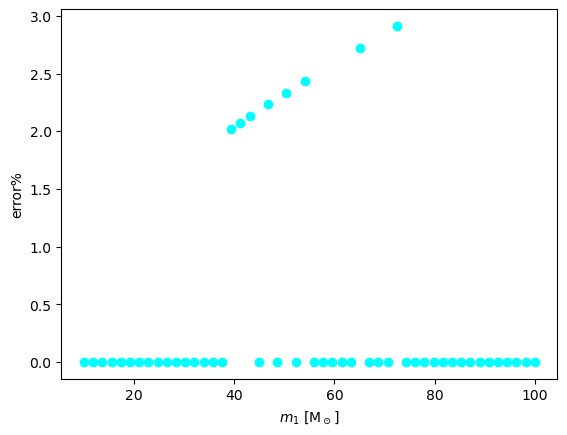

In [98]:
# Compare the SNRs
# Plot the relative difference (percentage error)
plt.plot(chirp_mass, np.abs(bilby_snrs3-my_snrs3)/bilby_snrs3*100, 'o', color='cyan')
plt.xlabel(r"$m_1$ [$\rm M_\odot$]")
plt.ylabel(r"error%")
plt.show()

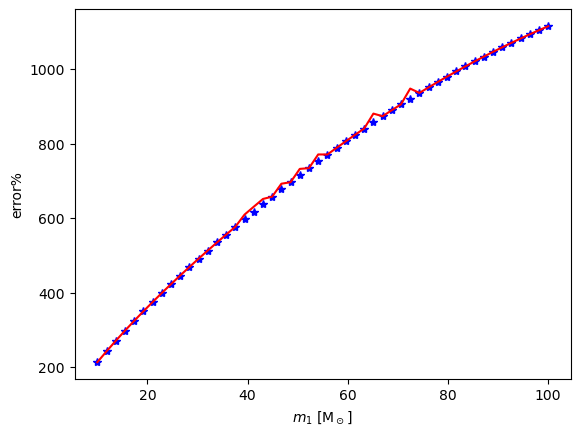

In [99]:
xx = chirp_mass
yy = bilby_snrs3
plt.plot(xx, yy , '*',color='blue')
yy = my_snrs3
plt.plot(xx, yy, color='red')

plt.xlabel(r"$m_1$ [$\rm M_\odot$]")
plt.ylabel(r"error%")
plt.show()